# Imports & Global Constants

In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb
import timm
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.amp import autocast, GradScaler

# visualization
import matplotlib.pyplot as plt

/data/ephemeral/home/pybum/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [4]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [5]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [6]:
BATCH_SIZE = 1
LR = 5e-6
RANDOM_SEED = 21
GRAD_ACCUM = 1

NUM_EPOCHS = 150
VAL_EVERY = 1

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [7]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [9]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [10]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [11]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [12]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [13]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5,shuffle=True, random_state=RANDOM_SEED)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        # image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            result = self.transforms(image=image, mask=label)
            image, label = result["image"], result["mask"]
        # to tenser will be done later
        # image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        # label = label.transpose(2, 0, 1)
        label = label.float()
        # image = torch.from_numpy(image).float()
        # label = torch.from_numpy(label).float()
            
        return image, label

In [14]:
class CSVPseudoTargetDataset(Dataset):
    """CSV(RLE) pseudo label을 target(mask)으로 사용하는 Dataset (XRayDataset 형식)"""
    def __init__(
        self,
        csv_path,
        image_root,
        transforms=None,
        target_size=(2048, 2048),
        is_train=True,
        pseudo_data_ratio=1.0,
    ):
        self.image_root = image_root
        self.transforms = transforms
        self.target_size = target_size
        self.is_train = is_train

        df = pd.read_csv(csv_path)

        # 이미지 리스트
        self.filenames = df["image_name"].unique().tolist()

        # image_name -> {class_name: rle}
        self.rle_dict = {}
        for img_name, g in df.groupby("image_name"):
            per_img = {}
            for _, row in g.iterrows():
                per_img[row["class"]] = row["rle"]
            self.rle_dict[img_name] = per_img

        # ratio 적용
        if pseudo_data_ratio < 1.0:
            n = int(len(self.filenames) * pseudo_data_ratio)
            random.shuffle(self.filenames)
            self.filenames = self.filenames[:n]

        print(f"[CSVPseudoTargetDataset] Loaded {len(self.filenames)} images from CSV")

    def _find_image_path(self, image_name):
        for root, _dirs, files in os.walk(self.image_root):
            for fname in files:
                if fname == image_name:
                    return os.path.join(root, fname)
        return None

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = self._find_image_path(image_name)

        image = cv2.imread(image_path)
        # image = image / 255.

        # (H, W, NC) 모양의 label 생성 (XRayDataset 스타일)
        H, W = self.target_size
        label_shape = (H, W, len(CLASSES))
        label = np.zeros(label_shape, dtype=np.uint8)

        # CSV(RLE) -> mask 채우기
        rle_data = self.rle_dict[image_name]
        for class_name, rle in rle_data.items():
            class_ind = CLASS2IND[class_name]
            mask = decode_rle_to_mask(rle, H, W)
            label[..., class_ind] = mask

        if self.transforms is not None:
            result = self.transforms(image=image, mask=label)
            image, label = result["image"], result["mask"]

        label = label.float()
        return image, label

# Check Data Sample

In [15]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# Augmentataion

In [16]:
# tf = A.Resize(640,640)
IMAGE_SIZE = 2048
train_tf = A.Compose([
    # A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.CropNonEmptyMaskIfExists(height=int(IMAGE_SIZE* 0.8), width=int(IMAGE_SIZE* 0.8),p=0.35),
    # A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=(0.8, 1.2),ratio=(1.0,1.0),p=0.4),
    A.CLAHE(clip_limit=1.0, p=0.3),
    # A.ElasticTransform(alpha=30,sigma=6,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0,approximate=False,p=0.3), 
    # A.RandomBrightnessContrast(brightness_limit=0.08,contrast_limit=0.2,p=0.4,),
    A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])
pseudo_tf = A.Compose([
    # A.Resize(2048, 2048),
    A.ShiftScaleRotate(
        shift_limit=0.1, 
        scale_limit=0.2, 
        rotate_limit=30, 
        border_mode=cv2.BORDER_CONSTANT, 
        value=0, mask_value=0,
        p=0.5
    ),
    
    A.RandomBrightnessContrast(
        brightness_limit=0.2, 
        contrast_limit=0.2, 
        p=0.5
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])

valid_tf = A.Compose([
    # A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225)),
    ToTensorV2(transpose_mask=True),
])

In [17]:
train_dataset = XRayDataset(is_train=True, transforms=train_tf)
pseudo_dataset = CSVPseudoTargetDataset(csv_path='./output (82).csv',image_root="../data/test/DCM",transforms=pseudo_tf)
valid_dataset = XRayDataset(is_train=False, transforms=valid_tf)

[CSVPseudoTargetDataset] Loaded 288 images from CSV


# Setup Dataloader

In [18]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=4,
    drop_last=True,
    num_workers=2,         
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=1,
)
pseudo_loader = DataLoader(
    dataset=pseudo_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=4,
    drop_last=True,
    num_workers=2,         
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=1,
)


valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

# Define Functions for Training

In [19]:
def decode_rle_to_mask(rle, height, width):
    """RLE로 인코딩된 결과를 mask map으로 복원합니다."""
    if pd.isna(rle) or rle == '':
        return np.zeros((height, width), dtype=np.uint8)
    
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)


In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [21]:
def save_model(model, file_name='models_best.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [22]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [23]:
def validation(epoch, model, data_loader, criterion, thr=0.5, use_amp=True):
    print(f'Start validation #{epoch:2d}')
    model.eval()
    # model = model.cuda()

    dices = []
    with torch.no_grad():
        total_loss = 0.0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()
            
            # outputs = model(images)['out']
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(pixel_values=images).logits
                # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)
                
            total_loss += loss.item()
            cnt += 1

            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach()
            masks = masks.detach()

            dice = dice_coef(outputs, masks)
            dices.append(dice.cpu())

    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    
    dice_str = "\n".join([f"{c:<12}: {d.item():.4f}" for c, d in zip(CLASSES, dices_per_class)])
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()
    avg_val_loss = total_loss / max(cnt, 1)  

    return avg_dice, avg_val_loss, dices_per_class.detach().cpu()


In [24]:
def train(model, data_loader, val_loader, criterion, optimizer, scheduler, accum_steps=4, use_amp=True):
    print(f'Start training..')

    best_dice = 0.0
    model = model.cuda()

    scaler = GradScaler(enabled=use_amp)

    wandb.init(
        project="segmentation",
        name=f"{model.__class__.__name__}",
        config={
            "batch_size": BATCH_SIZE,
            "num_epochs": NUM_EPOCHS,
            "val_every": VAL_EVERY,
            "thr": 0.5,
            "optimizer": optimizer.__class__.__name__,
            "lr": optimizer.param_groups[0].get("lr", None),
            "criterion": criterion.__class__.__name__,
            "model": model.__class__.__name__,
            "accum_steps": accum_steps,
            "use_amp": use_amp,
        }
    )

    global_step = 0

    for epoch in range(NUM_EPOCHS):
        model.train()

        pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", dynamic_ncols=True)

        optimizer.zero_grad(set_to_none=True)

        running_loss = 0.0
        running_count = 0

        for step, (images, masks) in enumerate(pbar):
            images, masks = images.cuda(), masks.cuda()

            #amp적용
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(pixel_values=images).logits
                # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_count += 1
            
            # 이번 스텝이 업데이트 시점인지/에폭 마지막인지 판단
            is_update = ((step + 1) % accum_steps == 0)
            is_last = ((step + 1) == len(data_loader))


            # AMP + grad accumulation
            scaler.scale(loss / accum_steps).backward()

            # 업데이트 시점 또는 마지막 남은 배치에서 step
            if is_update or is_last:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                global_step += 1
                current_lr = optimizer.param_groups[0]["lr"]

                # accum 구간 평균 loss 로깅
                avg_loss = running_loss / running_count
                wandb.log(
                    {"train/loss": avg_loss, "train/lr": current_lr, "epoch": epoch + 1},
                    step=global_step
                )

                pbar.set_postfix(loss=f"{avg_loss:.4f}")

                running_loss = 0.0
                running_count = 0
            else:
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            if (step + 1) % 25 == 0:
                tqdm.write(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(data_loader)}], '
                    f'Loss: {round(loss.item(), 4)}'
                )

        # scheduler.step()
        pbar.close()

        if (epoch + 1) % VAL_EVERY == 0:
            log_dict = {}
            dice, val_loss, dices_pc = validation(epoch + 1, model, val_loader, criterion, use_amp=use_amp)

            wandb.log(
                {"val/loss": val_loss, "val/dice": dice, "epoch": epoch + 1},
                step=global_step
            )

            for c, d in zip(CLASSES, dices_pc):
                log_dict[f"val/dice/{c}"] = float(d)
            wandb.log(log_dict)

            if best_dice < dice:
                tqdm.write(f"Best performance at epoch {epoch+1}: {best_dice:.4f} -> {dice:.4f}")
                tqdm.write(f"val_loss: {val_loss:.4f}")
                best_dice = dice
                save_model(model, file_name='swinupernet_pseudo.pt')

    wandb.finish()


# Losses

In [25]:
# single
# ABeDice안에서 dice를 사용하기 때문에 dice안에서는 sigmoid(pred)하면 안됨
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()  
    
    intersection = (pred * target).sum(dim=(2,3))
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth)))

    return loss.mean()

## p, pred, erc를 만들면서 vram많이 차지함 -> pred로 덮어쓰기 
# def ABeDice(pred, target, alpha=1, beta=1, smooth=1e-5):
#     pred= pred.contiguous()
#     target= target.contiguous()
#     pred = torch.sigmoid(pred)
    
#     t =1.0 
#     for _ in range(beta):
#         t = 1- pred**t
#     pred = pred ** (alpha * t)
    
#     return dice_loss(pred, target, smooth)
    
def ABeDice(pred, target, alpha=1, beta=1, smooth=1e-5):
    pred= pred.contiguous()
    target= target.contiguous()
    pred = torch.sigmoid(pred)
    
    t =1.0 
    for _ in range(beta):
        t = 1- pred**t
    pred = pred ** (alpha * t)
    
    intersection = (pred * target).sum(dim=(2, 3))
    p_sum = (pred**2).sum(dim=(2, 3))
    t_sum = (target**2).sum(dim=(2, 3)) 
    
    loss = 1 - ((2. * intersection + smooth) / (p_sum + t_sum + smooth))
    return loss.mean()

wrist_indices = [
    CLASSES.index("finger-1"),
    CLASSES.index("finger-17"),
    CLASSES.index("Trapezium"),
    CLASSES.index("Trapezoid"),
    CLASSES.index("Capitate"),
    CLASSES.index("Hamate"),
    CLASSES.index("Scaphoid"),
    CLASSES.index("Lunate"),
    CLASSES.index("Triquetrum"),
    CLASSES.index("Pisiform"),
]

def focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, smooth=1e-6, class_idx=None):
    pred= torch.sigmoid(pred).contiguous()
    target= target.contiguous()

    if class_idx is not None:
        pred= pred[:, class_idx, ...]
        target= target[:, class_idx, ...]
    
    dims = (2, 3)
    tp = (pred * target).sum(dim=dims)
    fp = (pred * (1 - target)).sum(dim=dims)
    fn = ((1 - pred) * target).sum(dim=dims)

    tversky= (tp+smooth) / (tp + alpha * fp + beta * fn+ smooth)
    loss= torch.pow((1-tversky), gamma)
    return loss.mean()

# multi 
def bce_dice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce* bce_weight + dice* (1 - bce_weight)
    return loss

def bce_abedice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    abe = ABeDice(pred, target, alpha=1, beta=1)
    loss = bce* bce_weight + abe * (1 - bce_weight)
    return loss
    
def bce_ftversky(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    focal_tversky = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=None)
    loss = bce * bce_weight + focal_tversky * (1 - bce_weight)
    return loss
    
def ABeDice_ftversky(pred, target, wrist_idx=wrist_indices, lam=2):
    base = ABeDice(pred,target, alpha=1, beta=1)
    wrist = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    return base + lam * wrist
    
def bce_ABeDice_ftversky(pred, target, wrist_idx=wrist_indices,bce_weight=0.33, ABe_weight=0.33, ft_weight=0.33):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    ABe = ABeDice(pred, target, alpha=1, beta=1)
    ft= focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    loss = bce* bce_weight + ABe * ABe_weight + ft * ft_weight
    return loss
    
def bce_Dice_ftversky(pred, target, wrist_idx=wrist_indices,bce_weight=0.4, Dice_weight=0.4, ft_weight=0.2):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    ft= focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    pred = torch.sigmoid(pred)
    Dice = dice_loss(pred, target)
    
    loss = bce* bce_weight + Dice * Dice_weight + ft * ft_weight

    return loss

# Training

In [26]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

NUM_CLASSES = 29  

# model = UperNetForSemanticSegmentation.from_pretrained(
#     "openmmlab/upernet-swin-base",
#     num_labels=NUM_CLASSES,
#     ignore_mismatched_sizes=True, 
# )
model= torch.load(os.path.join(SAVED_DIR, "swinupernet_best.pt"), map_location='cuda',weights_only=False)


# def replace_bn_with_gn(module, num_groups=32):
#     for name, child in module.named_children():
#         if isinstance(child, torch.nn.BatchNorm2d):
#             setattr(
#                 module,
#                 name,
#                 torch.nn.GroupNorm(
#                     num_groups=num_groups,
#                     num_channels=child.num_features
#                 )
#             )
#         else:
#             replace_bn_with_gn(child, num_groups)

# replace_bn_with_gn(model)
model = model.cuda()

In [27]:
# Loss function을 정의합니다.
# criterion = nn.BCEWithLogitsLoss()
criterion = bce_dice
# criterion = ABeDice

# criterion = ABeDice_ftversky
# criterion = bce_Dice_ftversky

# criterion = bce_abedice

# criterion = bce_ftversky


# Optimizer를 정의합니다.
optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=5e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=NUM_EPOCHS,eta_min=3e-5)



In [28]:
# 시드를 설정합니다.
set_seed()

In [29]:
train(model, pseudo_loader, valid_loader, criterion, optimizer, scheduler, GRAD_ACCUM, use_amp=True)

Start training..


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch 1/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 02:34:27 | Epoch [1/150], Step [25/288], Loss: 0.0081
2026-01-06 02:35:03 | Epoch [1/150], Step [50/288], Loss: 0.0062
2026-01-06 02:35:43 | Epoch [1/150], Step [75/288], Loss: 0.0053
2026-01-06 02:36:23 | Epoch [1/150], Step [100/288], Loss: 0.0083
2026-01-06 02:37:01 | Epoch [1/150], Step [125/288], Loss: 0.011
2026-01-06 02:37:39 | Epoch [1/150], Step [150/288], Loss: 0.0131
2026-01-06 02:38:19 | Epoch [1/150], Step [175/288], Loss: 0.0091
2026-01-06 02:38:57 | Epoch [1/150], Step [200/288], Loss: 0.0049
2026-01-06 02:39:36 | Epoch [1/150], Step [225/288], Loss: 0.009
2026-01-06 02:40:14 | Epoch [1/150], Step [250/288], Loss: 0.0066
2026-01-06 02:40:54 | Epoch [1/150], Step [275/288], Loss: 0.0129
Start validation # 1


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9616
finger-2    : 0.9839
finger-3    : 0.9815
finger-4    : 0.9775
finger-5    : 0.9777
finger-6    : 0.9879
finger-7    : 0.9862
finger-8    : 0.9803
finger-9    : 0.9816
finger-10   : 0.9892
finger-11   : 0.9791
finger-12   : 0.9779
finger-13   : 0.9808
finger-14   : 0.9880
finger-15   : 0.9818
finger-16   : 0.9734
finger-17   : 0.9724
finger-18   : 0.9858
finger-19   : 0.9863
Trapezium   : 0.9465
Trapezoid   : 0.9130
Capitate    : 0.9613
Hamate      : 0.9497
Scaphoid    : 0.9697
Lunate      : 0.9594
Triquetrum  : 0.9555
Pisiform    : 0.9134
Radius      : 0.9849
Ulna        : 0.9835
Best performance at epoch 1: 0.0000 -> 0.9714
val_loss: 0.0154


Epoch 2/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 02:43:51 | Epoch [2/150], Step [25/288], Loss: 0.0075
2026-01-06 02:44:30 | Epoch [2/150], Step [50/288], Loss: 0.0068
2026-01-06 02:45:07 | Epoch [2/150], Step [75/288], Loss: 0.0045
2026-01-06 02:45:44 | Epoch [2/150], Step [100/288], Loss: 0.0068
2026-01-06 02:46:22 | Epoch [2/150], Step [125/288], Loss: 0.0041
2026-01-06 02:47:01 | Epoch [2/150], Step [150/288], Loss: 0.0079
2026-01-06 02:47:40 | Epoch [2/150], Step [175/288], Loss: 0.0048
2026-01-06 02:48:20 | Epoch [2/150], Step [200/288], Loss: 0.0065
2026-01-06 02:48:59 | Epoch [2/150], Step [225/288], Loss: 0.0081
2026-01-06 02:49:37 | Epoch [2/150], Step [250/288], Loss: 0.0048
2026-01-06 02:50:15 | Epoch [2/150], Step [275/288], Loss: 0.0066
Start validation # 2


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9622
finger-2    : 0.9840
finger-3    : 0.9816
finger-4    : 0.9776
finger-5    : 0.9780
finger-6    : 0.9880
finger-7    : 0.9863
finger-8    : 0.9803
finger-9    : 0.9817
finger-10   : 0.9892
finger-11   : 0.9791
finger-12   : 0.9780
finger-13   : 0.9808
finger-14   : 0.9879
finger-15   : 0.9819
finger-16   : 0.9738
finger-17   : 0.9727
finger-18   : 0.9858
finger-19   : 0.9864
Trapezium   : 0.9475
Trapezoid   : 0.9145
Capitate    : 0.9617
Hamate      : 0.9501
Scaphoid    : 0.9701
Lunate      : 0.9596
Triquetrum  : 0.9554
Pisiform    : 0.9098
Radius      : 0.9848
Ulna        : 0.9834
Best performance at epoch 2: 0.9714 -> 0.9715
val_loss: 0.0153


Epoch 3/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 02:53:12 | Epoch [3/150], Step [25/288], Loss: 0.0047
2026-01-06 02:53:51 | Epoch [3/150], Step [50/288], Loss: 0.0068
2026-01-06 02:54:30 | Epoch [3/150], Step [75/288], Loss: 0.0062
2026-01-06 02:55:10 | Epoch [3/150], Step [100/288], Loss: 0.0046
2026-01-06 02:55:49 | Epoch [3/150], Step [125/288], Loss: 0.0067
2026-01-06 02:56:27 | Epoch [3/150], Step [150/288], Loss: 0.0056
2026-01-06 02:57:04 | Epoch [3/150], Step [175/288], Loss: 0.0077
2026-01-06 02:57:44 | Epoch [3/150], Step [200/288], Loss: 0.0053
2026-01-06 02:58:24 | Epoch [3/150], Step [225/288], Loss: 0.0049
2026-01-06 02:59:03 | Epoch [3/150], Step [250/288], Loss: 0.0036
2026-01-06 02:59:43 | Epoch [3/150], Step [275/288], Loss: 0.0061
Start validation # 3


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9626
finger-2    : 0.9840
finger-3    : 0.9816
finger-4    : 0.9779
finger-5    : 0.9780
finger-6    : 0.9879
finger-7    : 0.9863
finger-8    : 0.9805
finger-9    : 0.9818
finger-10   : 0.9893
finger-11   : 0.9792
finger-12   : 0.9781
finger-13   : 0.9810
finger-14   : 0.9880
finger-15   : 0.9821
finger-16   : 0.9736
finger-17   : 0.9728
finger-18   : 0.9858
finger-19   : 0.9863
Trapezium   : 0.9480
Trapezoid   : 0.9153
Capitate    : 0.9623
Hamate      : 0.9505
Scaphoid    : 0.9703
Lunate      : 0.9599
Triquetrum  : 0.9554
Pisiform    : 0.9129
Radius      : 0.9849
Ulna        : 0.9834
Best performance at epoch 3: 0.9715 -> 0.9717
val_loss: 0.0152


Epoch 4/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 03:02:42 | Epoch [4/150], Step [25/288], Loss: 0.0071
2026-01-06 03:03:20 | Epoch [4/150], Step [50/288], Loss: 0.0067
2026-01-06 03:04:00 | Epoch [4/150], Step [75/288], Loss: 0.008
2026-01-06 03:04:38 | Epoch [4/150], Step [100/288], Loss: 0.0057
2026-01-06 03:05:17 | Epoch [4/150], Step [125/288], Loss: 0.0054
2026-01-06 03:05:54 | Epoch [4/150], Step [150/288], Loss: 0.0062
2026-01-06 03:06:33 | Epoch [4/150], Step [175/288], Loss: 0.0044
2026-01-06 03:07:12 | Epoch [4/150], Step [200/288], Loss: 0.007
2026-01-06 03:07:51 | Epoch [4/150], Step [225/288], Loss: 0.0068
2026-01-06 03:08:30 | Epoch [4/150], Step [250/288], Loss: 0.0049
2026-01-06 03:09:10 | Epoch [4/150], Step [275/288], Loss: 0.0072
Start validation # 4


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9629
finger-2    : 0.9840
finger-3    : 0.9817
finger-4    : 0.9778
finger-5    : 0.9781
finger-6    : 0.9880
finger-7    : 0.9863
finger-8    : 0.9804
finger-9    : 0.9818
finger-10   : 0.9892
finger-11   : 0.9793
finger-12   : 0.9781
finger-13   : 0.9811
finger-14   : 0.9880
finger-15   : 0.9821
finger-16   : 0.9737
finger-17   : 0.9730
finger-18   : 0.9858
finger-19   : 0.9864
Trapezium   : 0.9480
Trapezoid   : 0.9153
Capitate    : 0.9624
Hamate      : 0.9504
Scaphoid    : 0.9705
Lunate      : 0.9599
Triquetrum  : 0.9545
Pisiform    : 0.9140
Radius      : 0.9848
Ulna        : 0.9833
Best performance at epoch 4: 0.9717 -> 0.9717
val_loss: 0.0152


Epoch 5/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 03:12:08 | Epoch [5/150], Step [25/288], Loss: 0.0077
2026-01-06 03:12:47 | Epoch [5/150], Step [50/288], Loss: 0.007
2026-01-06 03:13:27 | Epoch [5/150], Step [75/288], Loss: 0.0113
2026-01-06 03:14:05 | Epoch [5/150], Step [100/288], Loss: 0.0104
2026-01-06 03:14:43 | Epoch [5/150], Step [125/288], Loss: 0.0045
2026-01-06 03:15:23 | Epoch [5/150], Step [150/288], Loss: 0.004
2026-01-06 03:16:00 | Epoch [5/150], Step [175/288], Loss: 0.0068
2026-01-06 03:16:38 | Epoch [5/150], Step [200/288], Loss: 0.0069
2026-01-06 03:17:17 | Epoch [5/150], Step [225/288], Loss: 0.0066
2026-01-06 03:17:57 | Epoch [5/150], Step [250/288], Loss: 0.0076
2026-01-06 03:18:36 | Epoch [5/150], Step [275/288], Loss: 0.0067
Start validation # 5


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9630
finger-2    : 0.9841
finger-3    : 0.9816
finger-4    : 0.9780
finger-5    : 0.9782
finger-6    : 0.9880
finger-7    : 0.9862
finger-8    : 0.9805
finger-9    : 0.9819
finger-10   : 0.9893
finger-11   : 0.9793
finger-12   : 0.9780
finger-13   : 0.9811
finger-14   : 0.9880
finger-15   : 0.9821
finger-16   : 0.9736
finger-17   : 0.9729
finger-18   : 0.9858
finger-19   : 0.9865
Trapezium   : 0.9481
Trapezoid   : 0.9164
Capitate    : 0.9626
Hamate      : 0.9508
Scaphoid    : 0.9705
Lunate      : 0.9601
Triquetrum  : 0.9554
Pisiform    : 0.9133
Radius      : 0.9848
Ulna        : 0.9835
Best performance at epoch 5: 0.9717 -> 0.9719
val_loss: 0.0151


Epoch 6/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 03:21:33 | Epoch [6/150], Step [25/288], Loss: 0.0039
2026-01-06 03:22:12 | Epoch [6/150], Step [50/288], Loss: 0.01
2026-01-06 03:22:51 | Epoch [6/150], Step [75/288], Loss: 0.0071
2026-01-06 03:23:29 | Epoch [6/150], Step [100/288], Loss: 0.0052
2026-01-06 03:24:08 | Epoch [6/150], Step [125/288], Loss: 0.0065
2026-01-06 03:24:48 | Epoch [6/150], Step [150/288], Loss: 0.0181
2026-01-06 03:25:27 | Epoch [6/150], Step [175/288], Loss: 0.0089
2026-01-06 03:26:06 | Epoch [6/150], Step [200/288], Loss: 0.0048
2026-01-06 03:26:46 | Epoch [6/150], Step [225/288], Loss: 0.007
2026-01-06 03:27:25 | Epoch [6/150], Step [250/288], Loss: 0.0069
2026-01-06 03:28:04 | Epoch [6/150], Step [275/288], Loss: 0.0095
Start validation # 6


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9628
finger-2    : 0.9840
finger-3    : 0.9816
finger-4    : 0.9779
finger-5    : 0.9780
finger-6    : 0.9880
finger-7    : 0.9864
finger-8    : 0.9805
finger-9    : 0.9819
finger-10   : 0.9893
finger-11   : 0.9793
finger-12   : 0.9780
finger-13   : 0.9811
finger-14   : 0.9880
finger-15   : 0.9822
finger-16   : 0.9735
finger-17   : 0.9728
finger-18   : 0.9858
finger-19   : 0.9865
Trapezium   : 0.9485
Trapezoid   : 0.9162
Capitate    : 0.9626
Hamate      : 0.9507
Scaphoid    : 0.9707
Lunate      : 0.9603
Triquetrum  : 0.9555
Pisiform    : 0.9120
Radius      : 0.9849
Ulna        : 0.9833


Epoch 7/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 03:31:01 | Epoch [7/150], Step [25/288], Loss: 0.0166
2026-01-06 03:31:40 | Epoch [7/150], Step [50/288], Loss: 0.0096
2026-01-06 03:32:16 | Epoch [7/150], Step [75/288], Loss: 0.0043
2026-01-06 03:32:55 | Epoch [7/150], Step [100/288], Loss: 0.006
2026-01-06 03:33:34 | Epoch [7/150], Step [125/288], Loss: 0.0055
2026-01-06 03:34:13 | Epoch [7/150], Step [150/288], Loss: 0.0037
2026-01-06 03:34:52 | Epoch [7/150], Step [175/288], Loss: 0.0045
2026-01-06 03:35:32 | Epoch [7/150], Step [200/288], Loss: 0.0073
2026-01-06 03:36:11 | Epoch [7/150], Step [225/288], Loss: 0.0063
2026-01-06 03:36:48 | Epoch [7/150], Step [250/288], Loss: 0.0076
2026-01-06 03:37:25 | Epoch [7/150], Step [275/288], Loss: 0.0042
Start validation # 7


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9631
finger-2    : 0.9841
finger-3    : 0.9816
finger-4    : 0.9780
finger-5    : 0.9780
finger-6    : 0.9878
finger-7    : 0.9864
finger-8    : 0.9805
finger-9    : 0.9819
finger-10   : 0.9893
finger-11   : 0.9793
finger-12   : 0.9779
finger-13   : 0.9811
finger-14   : 0.9880
finger-15   : 0.9819
finger-16   : 0.9736
finger-17   : 0.9729
finger-18   : 0.9858
finger-19   : 0.9866
Trapezium   : 0.9489
Trapezoid   : 0.9173
Capitate    : 0.9629
Hamate      : 0.9509
Scaphoid    : 0.9703
Lunate      : 0.9603
Triquetrum  : 0.9556
Pisiform    : 0.9106
Radius      : 0.9849
Ulna        : 0.9833


Epoch 8/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 03:40:21 | Epoch [8/150], Step [25/288], Loss: 0.0042
2026-01-06 03:40:59 | Epoch [8/150], Step [50/288], Loss: 0.0083
2026-01-06 03:41:38 | Epoch [8/150], Step [75/288], Loss: 0.004
2026-01-06 03:42:17 | Epoch [8/150], Step [100/288], Loss: 0.009
2026-01-06 03:42:57 | Epoch [8/150], Step [125/288], Loss: 0.0048
2026-01-06 03:43:36 | Epoch [8/150], Step [150/288], Loss: 0.0067
2026-01-06 03:44:15 | Epoch [8/150], Step [175/288], Loss: 0.0065
2026-01-06 03:44:54 | Epoch [8/150], Step [200/288], Loss: 0.0045
2026-01-06 03:45:32 | Epoch [8/150], Step [225/288], Loss: 0.0042
2026-01-06 03:46:11 | Epoch [8/150], Step [250/288], Loss: 0.0046
2026-01-06 03:46:48 | Epoch [8/150], Step [275/288], Loss: 0.0069
Start validation # 8


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9632
finger-2    : 0.9841
finger-3    : 0.9816
finger-4    : 0.9781
finger-5    : 0.9781
finger-6    : 0.9880
finger-7    : 0.9864
finger-8    : 0.9807
finger-9    : 0.9820
finger-10   : 0.9893
finger-11   : 0.9794
finger-12   : 0.9781
finger-13   : 0.9812
finger-14   : 0.9880
finger-15   : 0.9822
finger-16   : 0.9739
finger-17   : 0.9731
finger-18   : 0.9858
finger-19   : 0.9865
Trapezium   : 0.9491
Trapezoid   : 0.9174
Capitate    : 0.9629
Hamate      : 0.9510
Scaphoid    : 0.9708
Lunate      : 0.9606
Triquetrum  : 0.9559
Pisiform    : 0.9147
Radius      : 0.9849
Ulna        : 0.9834
Best performance at epoch 8: 0.9719 -> 0.9721
val_loss: 0.0150


Epoch 9/150:   0%|                                                                              | 0/288 [00:00…

2026-01-06 03:49:47 | Epoch [9/150], Step [25/288], Loss: 0.004
2026-01-06 03:50:25 | Epoch [9/150], Step [50/288], Loss: 0.0037
2026-01-06 03:51:04 | Epoch [9/150], Step [75/288], Loss: 0.0044
2026-01-06 03:51:42 | Epoch [9/150], Step [100/288], Loss: 0.0051
2026-01-06 03:52:22 | Epoch [9/150], Step [125/288], Loss: 0.0069
2026-01-06 03:53:01 | Epoch [9/150], Step [150/288], Loss: 0.019
2026-01-06 03:53:40 | Epoch [9/150], Step [175/288], Loss: 0.0043
2026-01-06 03:54:20 | Epoch [9/150], Step [200/288], Loss: 0.0039
2026-01-06 03:55:00 | Epoch [9/150], Step [225/288], Loss: 0.0044
2026-01-06 03:55:39 | Epoch [9/150], Step [250/288], Loss: 0.0054
2026-01-06 03:56:18 | Epoch [9/150], Step [275/288], Loss: 0.0052
Start validation # 9


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9632
finger-2    : 0.9841
finger-3    : 0.9816
finger-4    : 0.9781
finger-5    : 0.9781
finger-6    : 0.9880
finger-7    : 0.9864
finger-8    : 0.9806
finger-9    : 0.9820
finger-10   : 0.9893
finger-11   : 0.9794
finger-12   : 0.9781
finger-13   : 0.9812
finger-14   : 0.9880
finger-15   : 0.9821
finger-16   : 0.9740
finger-17   : 0.9732
finger-18   : 0.9859
finger-19   : 0.9866
Trapezium   : 0.9492
Trapezoid   : 0.9175
Capitate    : 0.9631
Hamate      : 0.9515
Scaphoid    : 0.9708
Lunate      : 0.9605
Triquetrum  : 0.9559
Pisiform    : 0.9121
Radius      : 0.9849
Ulna        : 0.9834


Epoch 10/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 03:59:16 | Epoch [10/150], Step [25/288], Loss: 0.0071
2026-01-06 03:59:55 | Epoch [10/150], Step [50/288], Loss: 0.0243
2026-01-06 04:00:34 | Epoch [10/150], Step [75/288], Loss: 0.007
2026-01-06 04:01:14 | Epoch [10/150], Step [100/288], Loss: 0.0108
2026-01-06 04:01:53 | Epoch [10/150], Step [125/288], Loss: 0.0057
2026-01-06 04:02:31 | Epoch [10/150], Step [150/288], Loss: 0.0054
2026-01-06 04:03:09 | Epoch [10/150], Step [175/288], Loss: 0.0043
2026-01-06 04:03:49 | Epoch [10/150], Step [200/288], Loss: 0.0058
2026-01-06 04:04:28 | Epoch [10/150], Step [225/288], Loss: 0.0068
2026-01-06 04:05:07 | Epoch [10/150], Step [250/288], Loss: 0.0038
2026-01-06 04:05:46 | Epoch [10/150], Step [275/288], Loss: 0.0065
Start validation #10


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9633
finger-2    : 0.9841
finger-3    : 0.9817
finger-4    : 0.9780
finger-5    : 0.9781
finger-6    : 0.9880
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9820
finger-10   : 0.9893
finger-11   : 0.9793
finger-12   : 0.9781
finger-13   : 0.9812
finger-14   : 0.9878
finger-15   : 0.9823
finger-16   : 0.9737
finger-17   : 0.9732
finger-18   : 0.9859
finger-19   : 0.9866
Trapezium   : 0.9491
Trapezoid   : 0.9170
Capitate    : 0.9631
Hamate      : 0.9516
Scaphoid    : 0.9710
Lunate      : 0.9608
Triquetrum  : 0.9554
Pisiform    : 0.9143
Radius      : 0.9849
Ulna        : 0.9834
Best performance at epoch 10: 0.9721 -> 0.9721
val_loss: 0.0150


Epoch 11/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 04:08:47 | Epoch [11/150], Step [25/288], Loss: 0.0117
2026-01-06 04:09:25 | Epoch [11/150], Step [50/288], Loss: 0.0056
2026-01-06 04:10:05 | Epoch [11/150], Step [75/288], Loss: 0.0124
2026-01-06 04:10:43 | Epoch [11/150], Step [100/288], Loss: 0.004
2026-01-06 04:11:20 | Epoch [11/150], Step [125/288], Loss: 0.004
2026-01-06 04:12:00 | Epoch [11/150], Step [150/288], Loss: 0.0046
2026-01-06 04:12:38 | Epoch [11/150], Step [175/288], Loss: 0.0042
2026-01-06 04:13:18 | Epoch [11/150], Step [200/288], Loss: 0.0062
2026-01-06 04:13:58 | Epoch [11/150], Step [225/288], Loss: 0.0042
2026-01-06 04:14:38 | Epoch [11/150], Step [250/288], Loss: 0.0038
2026-01-06 04:15:17 | Epoch [11/150], Step [275/288], Loss: 0.0041
Start validation #11


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9633
finger-2    : 0.9841
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9782
finger-6    : 0.9880
finger-7    : 0.9864
finger-8    : 0.9806
finger-9    : 0.9820
finger-10   : 0.9893
finger-11   : 0.9795
finger-12   : 0.9783
finger-13   : 0.9812
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9740
finger-17   : 0.9732
finger-18   : 0.9859
finger-19   : 0.9866
Trapezium   : 0.9491
Trapezoid   : 0.9177
Capitate    : 0.9633
Hamate      : 0.9516
Scaphoid    : 0.9710
Lunate      : 0.9607
Triquetrum  : 0.9560
Pisiform    : 0.9119
Radius      : 0.9850
Ulna        : 0.9835
Best performance at epoch 11: 0.9721 -> 0.9721
val_loss: 0.0150


Epoch 12/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 04:18:17 | Epoch [12/150], Step [25/288], Loss: 0.0059
2026-01-06 04:18:56 | Epoch [12/150], Step [50/288], Loss: 0.0037
2026-01-06 04:19:37 | Epoch [12/150], Step [75/288], Loss: 0.0051
2026-01-06 04:20:13 | Epoch [12/150], Step [100/288], Loss: 0.004
2026-01-06 04:20:52 | Epoch [12/150], Step [125/288], Loss: 0.0068
2026-01-06 04:21:31 | Epoch [12/150], Step [150/288], Loss: 0.0046
2026-01-06 04:22:12 | Epoch [12/150], Step [175/288], Loss: 0.0103
2026-01-06 04:22:51 | Epoch [12/150], Step [200/288], Loss: 0.0044
2026-01-06 04:23:31 | Epoch [12/150], Step [225/288], Loss: 0.0057
2026-01-06 04:24:10 | Epoch [12/150], Step [250/288], Loss: 0.0038
2026-01-06 04:24:50 | Epoch [12/150], Step [275/288], Loss: 0.004
Start validation #12


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9633
finger-2    : 0.9841
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9783
finger-6    : 0.9880
finger-7    : 0.9863
finger-8    : 0.9807
finger-9    : 0.9821
finger-10   : 0.9894
finger-11   : 0.9794
finger-12   : 0.9782
finger-13   : 0.9812
finger-14   : 0.9881
finger-15   : 0.9823
finger-16   : 0.9740
finger-17   : 0.9731
finger-18   : 0.9859
finger-19   : 0.9865
Trapezium   : 0.9494
Trapezoid   : 0.9181
Capitate    : 0.9633
Hamate      : 0.9516
Scaphoid    : 0.9709
Lunate      : 0.9605
Triquetrum  : 0.9557
Pisiform    : 0.9129
Radius      : 0.9849
Ulna        : 0.9834
Best performance at epoch 12: 0.9721 -> 0.9721
val_loss: 0.0150


Epoch 13/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 04:27:47 | Epoch [13/150], Step [25/288], Loss: 0.0065
2026-01-06 04:28:27 | Epoch [13/150], Step [50/288], Loss: 0.0032
2026-01-06 04:29:06 | Epoch [13/150], Step [75/288], Loss: 0.0053
2026-01-06 04:29:46 | Epoch [13/150], Step [100/288], Loss: 0.0088
2026-01-06 04:30:25 | Epoch [13/150], Step [125/288], Loss: 0.0038
2026-01-06 04:31:05 | Epoch [13/150], Step [150/288], Loss: 0.0044
2026-01-06 04:31:45 | Epoch [13/150], Step [175/288], Loss: 0.0064
2026-01-06 04:32:22 | Epoch [13/150], Step [200/288], Loss: 0.0038
2026-01-06 04:33:00 | Epoch [13/150], Step [225/288], Loss: 0.0077
2026-01-06 04:33:39 | Epoch [13/150], Step [250/288], Loss: 0.0047
2026-01-06 04:34:18 | Epoch [13/150], Step [275/288], Loss: 0.004
Start validation #13


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9841
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9821
finger-10   : 0.9893
finger-11   : 0.9795
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9739
finger-17   : 0.9733
finger-18   : 0.9859
finger-19   : 0.9867
Trapezium   : 0.9496
Trapezoid   : 0.9182
Capitate    : 0.9635
Hamate      : 0.9516
Scaphoid    : 0.9711
Lunate      : 0.9609
Triquetrum  : 0.9561
Pisiform    : 0.9149
Radius      : 0.9850
Ulna        : 0.9835
Best performance at epoch 13: 0.9721 -> 0.9723
val_loss: 0.0149


Epoch 14/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 04:37:15 | Epoch [14/150], Step [25/288], Loss: 0.007
2026-01-06 04:37:52 | Epoch [14/150], Step [50/288], Loss: 0.004
2026-01-06 04:38:31 | Epoch [14/150], Step [75/288], Loss: 0.0042
2026-01-06 04:39:07 | Epoch [14/150], Step [100/288], Loss: 0.0041
2026-01-06 04:39:47 | Epoch [14/150], Step [125/288], Loss: 0.0059
2026-01-06 04:40:26 | Epoch [14/150], Step [150/288], Loss: 0.0036
2026-01-06 04:41:06 | Epoch [14/150], Step [175/288], Loss: 0.0058
2026-01-06 04:41:44 | Epoch [14/150], Step [200/288], Loss: 0.0067
2026-01-06 04:42:21 | Epoch [14/150], Step [225/288], Loss: 0.0034
2026-01-06 04:43:00 | Epoch [14/150], Step [250/288], Loss: 0.0075
2026-01-06 04:43:40 | Epoch [14/150], Step [275/288], Loss: 0.0068
Start validation #14


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9632
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9782
finger-5    : 0.9783
finger-6    : 0.9880
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9820
finger-10   : 0.9893
finger-11   : 0.9794
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9740
finger-17   : 0.9733
finger-18   : 0.9859
finger-19   : 0.9866
Trapezium   : 0.9491
Trapezoid   : 0.9178
Capitate    : 0.9635
Hamate      : 0.9515
Scaphoid    : 0.9711
Lunate      : 0.9610
Triquetrum  : 0.9555
Pisiform    : 0.9146
Radius      : 0.9850
Ulna        : 0.9835


Epoch 15/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 04:46:35 | Epoch [15/150], Step [25/288], Loss: 0.0036
2026-01-06 04:47:14 | Epoch [15/150], Step [50/288], Loss: 0.0038
2026-01-06 04:47:54 | Epoch [15/150], Step [75/288], Loss: 0.0064
2026-01-06 04:48:33 | Epoch [15/150], Step [100/288], Loss: 0.0057
2026-01-06 04:49:11 | Epoch [15/150], Step [125/288], Loss: 0.0049
2026-01-06 04:49:49 | Epoch [15/150], Step [150/288], Loss: 0.0076
2026-01-06 04:50:26 | Epoch [15/150], Step [175/288], Loss: 0.0055
2026-01-06 04:51:07 | Epoch [15/150], Step [200/288], Loss: 0.0072
2026-01-06 04:51:47 | Epoch [15/150], Step [225/288], Loss: 0.0087
2026-01-06 04:52:26 | Epoch [15/150], Step [250/288], Loss: 0.0038
2026-01-06 04:53:05 | Epoch [15/150], Step [275/288], Loss: 0.0069
Start validation #15


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9633
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9783
finger-6    : 0.9880
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9819
finger-10   : 0.9894
finger-11   : 0.9795
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9741
finger-17   : 0.9733
finger-18   : 0.9860
finger-19   : 0.9866
Trapezium   : 0.9499
Trapezoid   : 0.9182
Capitate    : 0.9635
Hamate      : 0.9517
Scaphoid    : 0.9710
Lunate      : 0.9610
Triquetrum  : 0.9562
Pisiform    : 0.9131
Radius      : 0.9850
Ulna        : 0.9834


Epoch 16/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 04:55:58 | Epoch [16/150], Step [25/288], Loss: 0.006
2026-01-06 04:56:37 | Epoch [16/150], Step [50/288], Loss: 0.0093
2026-01-06 04:57:15 | Epoch [16/150], Step [75/288], Loss: 0.0037
2026-01-06 04:57:55 | Epoch [16/150], Step [100/288], Loss: 0.0038
2026-01-06 04:58:33 | Epoch [16/150], Step [125/288], Loss: 0.0048
2026-01-06 04:59:12 | Epoch [16/150], Step [150/288], Loss: 0.0057
2026-01-06 04:59:52 | Epoch [16/150], Step [175/288], Loss: 0.0061
2026-01-06 05:00:31 | Epoch [16/150], Step [200/288], Loss: 0.0034
2026-01-06 05:01:12 | Epoch [16/150], Step [225/288], Loss: 0.0073
2026-01-06 05:01:49 | Epoch [16/150], Step [250/288], Loss: 0.004
2026-01-06 05:02:26 | Epoch [16/150], Step [275/288], Loss: 0.0042
Start validation #16


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9633
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9783
finger-6    : 0.9880
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9821
finger-10   : 0.9893
finger-11   : 0.9796
finger-12   : 0.9782
finger-13   : 0.9812
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9741
finger-17   : 0.9733
finger-18   : 0.9859
finger-19   : 0.9867
Trapezium   : 0.9498
Trapezoid   : 0.9183
Capitate    : 0.9635
Hamate      : 0.9518
Scaphoid    : 0.9710
Lunate      : 0.9609
Triquetrum  : 0.9561
Pisiform    : 0.9154
Radius      : 0.9850
Ulna        : 0.9834
Best performance at epoch 16: 0.9723 -> 0.9723
val_loss: 0.0149


Epoch 17/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 05:05:24 | Epoch [17/150], Step [25/288], Loss: 0.0056
2026-01-06 05:06:03 | Epoch [17/150], Step [50/288], Loss: 0.0053
2026-01-06 05:06:42 | Epoch [17/150], Step [75/288], Loss: 0.0035
2026-01-06 05:07:20 | Epoch [17/150], Step [100/288], Loss: 0.006
2026-01-06 05:08:00 | Epoch [17/150], Step [125/288], Loss: 0.0037
2026-01-06 05:08:39 | Epoch [17/150], Step [150/288], Loss: 0.0051
2026-01-06 05:09:16 | Epoch [17/150], Step [175/288], Loss: 0.0045
2026-01-06 05:09:55 | Epoch [17/150], Step [200/288], Loss: 0.0075
2026-01-06 05:10:34 | Epoch [17/150], Step [225/288], Loss: 0.0033
2026-01-06 05:11:15 | Epoch [17/150], Step [250/288], Loss: 0.004
2026-01-06 05:11:55 | Epoch [17/150], Step [275/288], Loss: 0.0086
Start validation #17


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9784
finger-6    : 0.9880
finger-7    : 0.9864
finger-8    : 0.9807
finger-9    : 0.9821
finger-10   : 0.9893
finger-11   : 0.9796
finger-12   : 0.9778
finger-13   : 0.9812
finger-14   : 0.9881
finger-15   : 0.9823
finger-16   : 0.9738
finger-17   : 0.9731
finger-18   : 0.9860
finger-19   : 0.9866
Trapezium   : 0.9498
Trapezoid   : 0.9184
Capitate    : 0.9636
Hamate      : 0.9519
Scaphoid    : 0.9711
Lunate      : 0.9611
Triquetrum  : 0.9560
Pisiform    : 0.9157
Radius      : 0.9849
Ulna        : 0.9832


Epoch 18/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 05:14:49 | Epoch [18/150], Step [25/288], Loss: 0.0052
2026-01-06 05:15:28 | Epoch [18/150], Step [50/288], Loss: 0.0061
2026-01-06 05:16:06 | Epoch [18/150], Step [75/288], Loss: 0.0048
2026-01-06 05:16:44 | Epoch [18/150], Step [100/288], Loss: 0.0048
2026-01-06 05:17:24 | Epoch [18/150], Step [125/288], Loss: 0.007
2026-01-06 05:18:02 | Epoch [18/150], Step [150/288], Loss: 0.0035
2026-01-06 05:18:42 | Epoch [18/150], Step [175/288], Loss: 0.0055
2026-01-06 05:19:20 | Epoch [18/150], Step [200/288], Loss: 0.0066
2026-01-06 05:20:01 | Epoch [18/150], Step [225/288], Loss: 0.0059
2026-01-06 05:20:40 | Epoch [18/150], Step [250/288], Loss: 0.0056
2026-01-06 05:21:18 | Epoch [18/150], Step [275/288], Loss: 0.0055
Start validation #18


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9783
finger-6    : 0.9881
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9821
finger-10   : 0.9893
finger-11   : 0.9796
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9823
finger-16   : 0.9740
finger-17   : 0.9732
finger-18   : 0.9860
finger-19   : 0.9866
Trapezium   : 0.9499
Trapezoid   : 0.9183
Capitate    : 0.9637
Hamate      : 0.9519
Scaphoid    : 0.9711
Lunate      : 0.9611
Triquetrum  : 0.9562
Pisiform    : 0.9138
Radius      : 0.9850
Ulna        : 0.9834


Epoch 19/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 05:24:12 | Epoch [19/150], Step [25/288], Loss: 0.0041
2026-01-06 05:24:53 | Epoch [19/150], Step [50/288], Loss: 0.0039
2026-01-06 05:25:32 | Epoch [19/150], Step [75/288], Loss: 0.0036
2026-01-06 05:26:10 | Epoch [19/150], Step [100/288], Loss: 0.0042
2026-01-06 05:26:49 | Epoch [19/150], Step [125/288], Loss: 0.0042
2026-01-06 05:27:28 | Epoch [19/150], Step [150/288], Loss: 0.0049
2026-01-06 05:28:06 | Epoch [19/150], Step [175/288], Loss: 0.0065
2026-01-06 05:28:45 | Epoch [19/150], Step [200/288], Loss: 0.0033
2026-01-06 05:29:24 | Epoch [19/150], Step [225/288], Loss: 0.0034
2026-01-06 05:30:03 | Epoch [19/150], Step [250/288], Loss: 0.0056
2026-01-06 05:30:41 | Epoch [19/150], Step [275/288], Loss: 0.0036
Start validation #19


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9635
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9779
finger-5    : 0.9782
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9821
finger-10   : 0.9893
finger-11   : 0.9797
finger-12   : 0.9783
finger-13   : 0.9812
finger-14   : 0.9881
finger-15   : 0.9823
finger-16   : 0.9742
finger-17   : 0.9729
finger-18   : 0.9858
finger-19   : 0.9867
Trapezium   : 0.9498
Trapezoid   : 0.9181
Capitate    : 0.9637
Hamate      : 0.9515
Scaphoid    : 0.9710
Lunate      : 0.9612
Triquetrum  : 0.9560
Pisiform    : 0.9152
Radius      : 0.9850
Ulna        : 0.9835


Epoch 20/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 05:33:38 | Epoch [20/150], Step [25/288], Loss: 0.0068
2026-01-06 05:34:17 | Epoch [20/150], Step [50/288], Loss: 0.0033
2026-01-06 05:34:55 | Epoch [20/150], Step [75/288], Loss: 0.0032
2026-01-06 05:35:36 | Epoch [20/150], Step [100/288], Loss: 0.01
2026-01-06 05:36:16 | Epoch [20/150], Step [125/288], Loss: 0.006
2026-01-06 05:36:54 | Epoch [20/150], Step [150/288], Loss: 0.009
2026-01-06 05:37:33 | Epoch [20/150], Step [175/288], Loss: 0.0073
2026-01-06 05:38:12 | Epoch [20/150], Step [200/288], Loss: 0.0042
2026-01-06 05:38:52 | Epoch [20/150], Step [225/288], Loss: 0.0041
2026-01-06 05:39:32 | Epoch [20/150], Step [250/288], Loss: 0.0054
2026-01-06 05:40:10 | Epoch [20/150], Step [275/288], Loss: 0.0069
Start validation #20


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9782
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9807
finger-9    : 0.9822
finger-10   : 0.9893
finger-11   : 0.9796
finger-12   : 0.9780
finger-13   : 0.9812
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9741
finger-17   : 0.9730
finger-18   : 0.9858
finger-19   : 0.9867
Trapezium   : 0.9497
Trapezoid   : 0.9190
Capitate    : 0.9637
Hamate      : 0.9520
Scaphoid    : 0.9712
Lunate      : 0.9611
Triquetrum  : 0.9555
Pisiform    : 0.9150
Radius      : 0.9850
Ulna        : 0.9834
Best performance at epoch 20: 0.9723 -> 0.9723
val_loss: 0.0149


Epoch 21/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 05:43:09 | Epoch [21/150], Step [25/288], Loss: 0.0059
2026-01-06 05:43:48 | Epoch [21/150], Step [50/288], Loss: 0.0039
2026-01-06 05:44:25 | Epoch [21/150], Step [75/288], Loss: 0.0071
2026-01-06 05:45:04 | Epoch [21/150], Step [100/288], Loss: 0.0059
2026-01-06 05:45:41 | Epoch [21/150], Step [125/288], Loss: 0.0036
2026-01-06 05:46:22 | Epoch [21/150], Step [150/288], Loss: 0.0059
2026-01-06 05:47:01 | Epoch [21/150], Step [175/288], Loss: 0.0059
2026-01-06 05:47:40 | Epoch [21/150], Step [200/288], Loss: 0.0067
2026-01-06 05:48:19 | Epoch [21/150], Step [225/288], Loss: 0.0061
2026-01-06 05:48:57 | Epoch [21/150], Step [250/288], Loss: 0.0034
2026-01-06 05:49:37 | Epoch [21/150], Step [275/288], Loss: 0.0057
Start validation #21


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9780
finger-5    : 0.9783
finger-6    : 0.9880
finger-7    : 0.9866
finger-8    : 0.9802
finger-9    : 0.9820
finger-10   : 0.9893
finger-11   : 0.9795
finger-12   : 0.9781
finger-13   : 0.9811
finger-14   : 0.9881
finger-15   : 0.9822
finger-16   : 0.9741
finger-17   : 0.9732
finger-18   : 0.9859
finger-19   : 0.9867
Trapezium   : 0.9492
Trapezoid   : 0.9189
Capitate    : 0.9637
Hamate      : 0.9521
Scaphoid    : 0.9713
Lunate      : 0.9612
Triquetrum  : 0.9560
Pisiform    : 0.9152
Radius      : 0.9850
Ulna        : 0.9834


Epoch 22/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 05:52:36 | Epoch [22/150], Step [25/288], Loss: 0.0049
2026-01-06 05:53:15 | Epoch [22/150], Step [50/288], Loss: 0.0077
2026-01-06 05:53:54 | Epoch [22/150], Step [75/288], Loss: 0.0093
2026-01-06 05:54:32 | Epoch [22/150], Step [100/288], Loss: 0.0035
2026-01-06 05:55:14 | Epoch [22/150], Step [125/288], Loss: 0.0066
2026-01-06 05:55:51 | Epoch [22/150], Step [150/288], Loss: 0.0049
2026-01-06 05:56:31 | Epoch [22/150], Step [175/288], Loss: 0.0054
2026-01-06 05:57:11 | Epoch [22/150], Step [200/288], Loss: 0.0034
2026-01-06 05:57:50 | Epoch [22/150], Step [225/288], Loss: 0.0058
2026-01-06 05:58:28 | Epoch [22/150], Step [250/288], Loss: 0.0051
2026-01-06 05:59:07 | Epoch [22/150], Step [275/288], Loss: 0.005
Start validation #22


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9636
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9783
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9807
finger-9    : 0.9821
finger-10   : 0.9894
finger-11   : 0.9796
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9823
finger-16   : 0.9742
finger-17   : 0.9733
finger-18   : 0.9859
finger-19   : 0.9867
Trapezium   : 0.9500
Trapezoid   : 0.9184
Capitate    : 0.9637
Hamate      : 0.9521
Scaphoid    : 0.9710
Lunate      : 0.9612
Triquetrum  : 0.9562
Pisiform    : 0.9153
Radius      : 0.9850
Ulna        : 0.9835
Best performance at epoch 22: 0.9723 -> 0.9724
val_loss: 0.0149


Epoch 23/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 06:02:07 | Epoch [23/150], Step [25/288], Loss: 0.0061
2026-01-06 06:02:44 | Epoch [23/150], Step [50/288], Loss: 0.0031
2026-01-06 06:03:23 | Epoch [23/150], Step [75/288], Loss: 0.0064
2026-01-06 06:04:02 | Epoch [23/150], Step [100/288], Loss: 0.0344
2026-01-06 06:04:42 | Epoch [23/150], Step [125/288], Loss: 0.0051
2026-01-06 06:05:20 | Epoch [23/150], Step [150/288], Loss: 0.0058
2026-01-06 06:05:58 | Epoch [23/150], Step [175/288], Loss: 0.0036
2026-01-06 06:06:37 | Epoch [23/150], Step [200/288], Loss: 0.0035
2026-01-06 06:07:16 | Epoch [23/150], Step [225/288], Loss: 0.0037
2026-01-06 06:07:56 | Epoch [23/150], Step [250/288], Loss: 0.0032
2026-01-06 06:08:35 | Epoch [23/150], Step [275/288], Loss: 0.003
Start validation #23


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9780
finger-5    : 0.9783
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9821
finger-10   : 0.9894
finger-11   : 0.9796
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9741
finger-17   : 0.9734
finger-18   : 0.9859
finger-19   : 0.9868
Trapezium   : 0.9501
Trapezoid   : 0.9191
Capitate    : 0.9634
Hamate      : 0.9520
Scaphoid    : 0.9712
Lunate      : 0.9612
Triquetrum  : 0.9565
Pisiform    : 0.9141
Radius      : 0.9850
Ulna        : 0.9835


Epoch 24/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 06:11:29 | Epoch [24/150], Step [25/288], Loss: 0.0034
2026-01-06 06:12:07 | Epoch [24/150], Step [50/288], Loss: 0.0034
2026-01-06 06:12:46 | Epoch [24/150], Step [75/288], Loss: 0.0064
2026-01-06 06:13:24 | Epoch [24/150], Step [100/288], Loss: 0.003
2026-01-06 06:14:03 | Epoch [24/150], Step [125/288], Loss: 0.0072
2026-01-06 06:14:43 | Epoch [24/150], Step [150/288], Loss: 0.0077
2026-01-06 06:15:22 | Epoch [24/150], Step [175/288], Loss: 0.0075
2026-01-06 06:15:59 | Epoch [24/150], Step [200/288], Loss: 0.0056
2026-01-06 06:16:39 | Epoch [24/150], Step [225/288], Loss: 0.0051
2026-01-06 06:17:16 | Epoch [24/150], Step [250/288], Loss: 0.0033
2026-01-06 06:17:57 | Epoch [24/150], Step [275/288], Loss: 0.0096
Start validation #24


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9782
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9865
finger-8    : 0.9808
finger-9    : 0.9822
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9742
finger-17   : 0.9734
finger-18   : 0.9860
finger-19   : 0.9866
Trapezium   : 0.9502
Trapezoid   : 0.9189
Capitate    : 0.9639
Hamate      : 0.9520
Scaphoid    : 0.9712
Lunate      : 0.9612
Triquetrum  : 0.9560
Pisiform    : 0.9136
Radius      : 0.9850
Ulna        : 0.9835


Epoch 25/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 06:20:51 | Epoch [25/150], Step [25/288], Loss: 0.0068
2026-01-06 06:21:30 | Epoch [25/150], Step [50/288], Loss: 0.006
2026-01-06 06:22:08 | Epoch [25/150], Step [75/288], Loss: 0.0036
2026-01-06 06:22:46 | Epoch [25/150], Step [100/288], Loss: 0.0039
2026-01-06 06:23:26 | Epoch [25/150], Step [125/288], Loss: 0.0055
2026-01-06 06:24:06 | Epoch [25/150], Step [150/288], Loss: 0.0056
2026-01-06 06:24:44 | Epoch [25/150], Step [175/288], Loss: 0.0039
2026-01-06 06:25:25 | Epoch [25/150], Step [200/288], Loss: 0.0037
2026-01-06 06:26:04 | Epoch [25/150], Step [225/288], Loss: 0.0064
2026-01-06 06:26:44 | Epoch [25/150], Step [250/288], Loss: 0.0053
2026-01-06 06:27:22 | Epoch [25/150], Step [275/288], Loss: 0.0033
Start validation #25


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9818
finger-4    : 0.9780
finger-5    : 0.9784
finger-6    : 0.9880
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9822
finger-10   : 0.9889
finger-11   : 0.9797
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9876
finger-15   : 0.9824
finger-16   : 0.9739
finger-17   : 0.9734
finger-18   : 0.9859
finger-19   : 0.9867
Trapezium   : 0.9499
Trapezoid   : 0.9191
Capitate    : 0.9637
Hamate      : 0.9521
Scaphoid    : 0.9711
Lunate      : 0.9613
Triquetrum  : 0.9559
Pisiform    : 0.9154
Radius      : 0.9850
Ulna        : 0.9834


Epoch 26/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 06:30:20 | Epoch [26/150], Step [25/288], Loss: 0.0033
2026-01-06 06:30:57 | Epoch [26/150], Step [50/288], Loss: 0.0053
2026-01-06 06:31:37 | Epoch [26/150], Step [75/288], Loss: 0.0069
2026-01-06 06:32:14 | Epoch [26/150], Step [100/288], Loss: 0.0035
2026-01-06 06:32:52 | Epoch [26/150], Step [125/288], Loss: 0.0052
2026-01-06 06:33:31 | Epoch [26/150], Step [150/288], Loss: 0.0067
2026-01-06 06:34:10 | Epoch [26/150], Step [175/288], Loss: 0.0035
2026-01-06 06:34:48 | Epoch [26/150], Step [200/288], Loss: 0.0033
2026-01-06 06:35:28 | Epoch [26/150], Step [225/288], Loss: 0.0047
2026-01-06 06:36:06 | Epoch [26/150], Step [250/288], Loss: 0.0033
2026-01-06 06:36:47 | Epoch [26/150], Step [275/288], Loss: 0.0056
Start validation #26


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9817
finger-4    : 0.9779
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9807
finger-9    : 0.9820
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9742
finger-17   : 0.9734
finger-18   : 0.9859
finger-19   : 0.9867
Trapezium   : 0.9501
Trapezoid   : 0.9194
Capitate    : 0.9640
Hamate      : 0.9521
Scaphoid    : 0.9710
Lunate      : 0.9614
Triquetrum  : 0.9564
Pisiform    : 0.9159
Radius      : 0.9850
Ulna        : 0.9834
Best performance at epoch 26: 0.9724 -> 0.9724
val_loss: 0.0148


Epoch 27/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 06:39:47 | Epoch [27/150], Step [25/288], Loss: 0.0059
2026-01-06 06:40:25 | Epoch [27/150], Step [50/288], Loss: 0.0063
2026-01-06 06:41:06 | Epoch [27/150], Step [75/288], Loss: 0.0056
2026-01-06 06:41:44 | Epoch [27/150], Step [100/288], Loss: 0.0032
2026-01-06 06:42:24 | Epoch [27/150], Step [125/288], Loss: 0.0068
2026-01-06 06:43:04 | Epoch [27/150], Step [150/288], Loss: 0.0048
2026-01-06 06:43:42 | Epoch [27/150], Step [175/288], Loss: 0.004
2026-01-06 06:44:22 | Epoch [27/150], Step [200/288], Loss: 0.0058
2026-01-06 06:45:01 | Epoch [27/150], Step [225/288], Loss: 0.0075
2026-01-06 06:45:40 | Epoch [27/150], Step [250/288], Loss: 0.0033
2026-01-06 06:46:19 | Epoch [27/150], Step [275/288], Loss: 0.0056
Start validation #27


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9843
finger-3    : 0.9818
finger-4    : 0.9782
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9821
finger-10   : 0.9893
finger-11   : 0.9797
finger-12   : 0.9784
finger-13   : 0.9812
finger-14   : 0.9881
finger-15   : 0.9823
finger-16   : 0.9740
finger-17   : 0.9735
finger-18   : 0.9859
finger-19   : 0.9866
Trapezium   : 0.9502
Trapezoid   : 0.9188
Capitate    : 0.9638
Hamate      : 0.9516
Scaphoid    : 0.9711
Lunate      : 0.9612
Triquetrum  : 0.9563
Pisiform    : 0.9160
Radius      : 0.9850
Ulna        : 0.9834


Epoch 28/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 06:49:16 | Epoch [28/150], Step [25/288], Loss: 0.0035
2026-01-06 06:49:56 | Epoch [28/150], Step [50/288], Loss: 0.008
2026-01-06 06:50:35 | Epoch [28/150], Step [75/288], Loss: 0.0035
2026-01-06 06:51:15 | Epoch [28/150], Step [100/288], Loss: 0.0039
2026-01-06 06:51:54 | Epoch [28/150], Step [125/288], Loss: 0.0062
2026-01-06 06:52:35 | Epoch [28/150], Step [150/288], Loss: 0.0058
2026-01-06 06:53:14 | Epoch [28/150], Step [175/288], Loss: 0.0034
2026-01-06 06:53:53 | Epoch [28/150], Step [200/288], Loss: 0.0052
2026-01-06 06:54:32 | Epoch [28/150], Step [225/288], Loss: 0.0031
2026-01-06 06:55:13 | Epoch [28/150], Step [250/288], Loss: 0.0057
2026-01-06 06:55:52 | Epoch [28/150], Step [275/288], Loss: 0.0034
Start validation #28


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9818
finger-4    : 0.9780
finger-5    : 0.9782
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9822
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9781
finger-13   : 0.9812
finger-14   : 0.9881
finger-15   : 0.9823
finger-16   : 0.9739
finger-17   : 0.9733
finger-18   : 0.9859
finger-19   : 0.9868
Trapezium   : 0.9503
Trapezoid   : 0.9188
Capitate    : 0.9636
Hamate      : 0.9519
Scaphoid    : 0.9712
Lunate      : 0.9614
Triquetrum  : 0.9563
Pisiform    : 0.9123
Radius      : 0.9850
Ulna        : 0.9834


Epoch 29/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 06:58:48 | Epoch [29/150], Step [25/288], Loss: 0.0049
2026-01-06 06:59:27 | Epoch [29/150], Step [50/288], Loss: 0.0061
2026-01-06 07:00:07 | Epoch [29/150], Step [75/288], Loss: 0.0057
2026-01-06 07:00:47 | Epoch [29/150], Step [100/288], Loss: 0.0038
2026-01-06 07:01:28 | Epoch [29/150], Step [125/288], Loss: 0.0229
2026-01-06 07:02:04 | Epoch [29/150], Step [150/288], Loss: 0.0035
2026-01-06 07:02:45 | Epoch [29/150], Step [175/288], Loss: 0.0037
2026-01-06 07:03:25 | Epoch [29/150], Step [200/288], Loss: 0.0052
2026-01-06 07:04:04 | Epoch [29/150], Step [225/288], Loss: 0.0033
2026-01-06 07:04:43 | Epoch [29/150], Step [250/288], Loss: 0.0054
2026-01-06 07:05:22 | Epoch [29/150], Step [275/288], Loss: 0.0068
Start validation #29


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9818
finger-4    : 0.9781
finger-5    : 0.9783
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9821
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9822
finger-16   : 0.9739
finger-17   : 0.9734
finger-18   : 0.9860
finger-19   : 0.9867
Trapezium   : 0.9504
Trapezoid   : 0.9192
Capitate    : 0.9640
Hamate      : 0.9522
Scaphoid    : 0.9714
Lunate      : 0.9614
Triquetrum  : 0.9562
Pisiform    : 0.9154
Radius      : 0.9850
Ulna        : 0.9835
Best performance at epoch 29: 0.9724 -> 0.9725
val_loss: 0.0148


Epoch 30/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 07:08:21 | Epoch [30/150], Step [25/288], Loss: 0.0039
2026-01-06 07:09:02 | Epoch [30/150], Step [50/288], Loss: 0.0073
2026-01-06 07:09:40 | Epoch [30/150], Step [75/288], Loss: 0.0051
2026-01-06 07:10:21 | Epoch [30/150], Step [100/288], Loss: 0.0028
2026-01-06 07:11:00 | Epoch [30/150], Step [125/288], Loss: 0.0065
2026-01-06 07:11:39 | Epoch [30/150], Step [150/288], Loss: 0.0032
2026-01-06 07:12:17 | Epoch [30/150], Step [175/288], Loss: 0.0035
2026-01-06 07:12:55 | Epoch [30/150], Step [200/288], Loss: 0.0035
2026-01-06 07:13:35 | Epoch [30/150], Step [225/288], Loss: 0.0056
2026-01-06 07:14:15 | Epoch [30/150], Step [250/288], Loss: 0.0065
2026-01-06 07:14:54 | Epoch [30/150], Step [275/288], Loss: 0.0061
Start validation #30


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9633
finger-2    : 0.9843
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9783
finger-6    : 0.9881
finger-7    : 0.9865
finger-8    : 0.9807
finger-9    : 0.9822
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9782
finger-13   : 0.9812
finger-14   : 0.9880
finger-15   : 0.9823
finger-16   : 0.9737
finger-17   : 0.9733
finger-18   : 0.9858
finger-19   : 0.9867
Trapezium   : 0.9504
Trapezoid   : 0.9191
Capitate    : 0.9640
Hamate      : 0.9521
Scaphoid    : 0.9712
Lunate      : 0.9612
Triquetrum  : 0.9564
Pisiform    : 0.9154
Radius      : 0.9850
Ulna        : 0.9834


Epoch 31/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 07:17:50 | Epoch [31/150], Step [25/288], Loss: 0.003
2026-01-06 07:18:27 | Epoch [31/150], Step [50/288], Loss: 0.003
2026-01-06 07:19:08 | Epoch [31/150], Step [75/288], Loss: 0.0059
2026-01-06 07:19:47 | Epoch [31/150], Step [100/288], Loss: 0.0048
2026-01-06 07:20:25 | Epoch [31/150], Step [125/288], Loss: 0.0033
2026-01-06 07:21:05 | Epoch [31/150], Step [150/288], Loss: 0.0106
2026-01-06 07:21:45 | Epoch [31/150], Step [175/288], Loss: 0.0052
2026-01-06 07:22:24 | Epoch [31/150], Step [200/288], Loss: 0.0057
2026-01-06 07:23:04 | Epoch [31/150], Step [225/288], Loss: 0.0086
2026-01-06 07:23:44 | Epoch [31/150], Step [250/288], Loss: 0.0061
2026-01-06 07:24:22 | Epoch [31/150], Step [275/288], Loss: 0.0052
Start validation #31


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9633
finger-2    : 0.9843
finger-3    : 0.9817
finger-4    : 0.9781
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9820
finger-10   : 0.9894
finger-11   : 0.9796
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9739
finger-17   : 0.9733
finger-18   : 0.9860
finger-19   : 0.9868
Trapezium   : 0.9504
Trapezoid   : 0.9192
Capitate    : 0.9638
Hamate      : 0.9523
Scaphoid    : 0.9713
Lunate      : 0.9612
Triquetrum  : 0.9563
Pisiform    : 0.9164
Radius      : 0.9850
Ulna        : 0.9834
Best performance at epoch 31: 0.9725 -> 0.9725
val_loss: 0.0148


Epoch 32/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 07:27:22 | Epoch [32/150], Step [25/288], Loss: 0.0063
2026-01-06 07:28:02 | Epoch [32/150], Step [50/288], Loss: 0.0062
2026-01-06 07:28:42 | Epoch [32/150], Step [75/288], Loss: 0.0057
2026-01-06 07:29:21 | Epoch [32/150], Step [100/288], Loss: 0.007
2026-01-06 07:30:00 | Epoch [32/150], Step [125/288], Loss: 0.0053
2026-01-06 07:30:39 | Epoch [32/150], Step [150/288], Loss: 0.0032
2026-01-06 07:31:18 | Epoch [32/150], Step [175/288], Loss: 0.0038
2026-01-06 07:31:57 | Epoch [32/150], Step [200/288], Loss: 0.0045
2026-01-06 07:32:36 | Epoch [32/150], Step [225/288], Loss: 0.0033
2026-01-06 07:33:14 | Epoch [32/150], Step [250/288], Loss: 0.0033
2026-01-06 07:33:53 | Epoch [32/150], Step [275/288], Loss: 0.0035
Start validation #32


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9843
finger-3    : 0.9818
finger-4    : 0.9782
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9821
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9783
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9740
finger-17   : 0.9734
finger-18   : 0.9859
finger-19   : 0.9868
Trapezium   : 0.9505
Trapezoid   : 0.9188
Capitate    : 0.9640
Hamate      : 0.9522
Scaphoid    : 0.9713
Lunate      : 0.9616
Triquetrum  : 0.9562
Pisiform    : 0.9176
Radius      : 0.9850
Ulna        : 0.9834
Best performance at epoch 32: 0.9725 -> 0.9725
val_loss: 0.0148


Epoch 33/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 07:36:50 | Epoch [33/150], Step [25/288], Loss: 0.003
2026-01-06 07:37:31 | Epoch [33/150], Step [50/288], Loss: 0.0055
2026-01-06 07:38:10 | Epoch [33/150], Step [75/288], Loss: 0.0035
2026-01-06 07:38:49 | Epoch [33/150], Step [100/288], Loss: 0.003
2026-01-06 07:39:28 | Epoch [33/150], Step [125/288], Loss: 0.0056
2026-01-06 07:40:08 | Epoch [33/150], Step [150/288], Loss: 0.0068
2026-01-06 07:40:47 | Epoch [33/150], Step [175/288], Loss: 0.0035
2026-01-06 07:41:27 | Epoch [33/150], Step [200/288], Loss: 0.006
2026-01-06 07:42:06 | Epoch [33/150], Step [225/288], Loss: 0.0036
2026-01-06 07:42:46 | Epoch [33/150], Step [250/288], Loss: 0.0055
2026-01-06 07:43:22 | Epoch [33/150], Step [275/288], Loss: 0.0031
Start validation #33


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9843
finger-3    : 0.9818
finger-4    : 0.9782
finger-5    : 0.9785
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9809
finger-9    : 0.9821
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9825
finger-16   : 0.9741
finger-17   : 0.9735
finger-18   : 0.9860
finger-19   : 0.9867
Trapezium   : 0.9505
Trapezoid   : 0.9193
Capitate    : 0.9639
Hamate      : 0.9523
Scaphoid    : 0.9714
Lunate      : 0.9615
Triquetrum  : 0.9562
Pisiform    : 0.9168
Radius      : 0.9850
Ulna        : 0.9834
Best performance at epoch 33: 0.9725 -> 0.9725
val_loss: 0.0148


Epoch 34/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 07:46:21 | Epoch [34/150], Step [25/288], Loss: 0.0059
2026-01-06 07:46:59 | Epoch [34/150], Step [50/288], Loss: 0.0029
2026-01-06 07:47:39 | Epoch [34/150], Step [75/288], Loss: 0.0048
2026-01-06 07:48:18 | Epoch [34/150], Step [100/288], Loss: 0.0036
2026-01-06 07:48:58 | Epoch [34/150], Step [125/288], Loss: 0.006
2026-01-06 07:49:37 | Epoch [34/150], Step [150/288], Loss: 0.0034
2026-01-06 07:50:14 | Epoch [34/150], Step [175/288], Loss: 0.003
2026-01-06 07:50:51 | Epoch [34/150], Step [200/288], Loss: 0.0026
2026-01-06 07:51:31 | Epoch [34/150], Step [225/288], Loss: 0.0038
2026-01-06 07:52:10 | Epoch [34/150], Step [250/288], Loss: 0.0055
2026-01-06 07:52:48 | Epoch [34/150], Step [275/288], Loss: 0.0029
Start validation #34


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9843
finger-3    : 0.9818
finger-4    : 0.9783
finger-5    : 0.9785
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9809
finger-9    : 0.9822
finger-10   : 0.9894
finger-11   : 0.9798
finger-12   : 0.9785
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9741
finger-17   : 0.9735
finger-18   : 0.9860
finger-19   : 0.9868
Trapezium   : 0.9503
Trapezoid   : 0.9195
Capitate    : 0.9640
Hamate      : 0.9521
Scaphoid    : 0.9713
Lunate      : 0.9615
Triquetrum  : 0.9562
Pisiform    : 0.9152
Radius      : 0.9850
Ulna        : 0.9835


Epoch 35/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 07:55:42 | Epoch [35/150], Step [25/288], Loss: 0.0037
2026-01-06 07:56:21 | Epoch [35/150], Step [50/288], Loss: 0.0032
2026-01-06 07:56:59 | Epoch [35/150], Step [75/288], Loss: 0.0028
2026-01-06 07:57:39 | Epoch [35/150], Step [100/288], Loss: 0.006
2026-01-06 07:58:17 | Epoch [35/150], Step [125/288], Loss: 0.0035
2026-01-06 07:58:56 | Epoch [35/150], Step [150/288], Loss: 0.0032
2026-01-06 07:59:36 | Epoch [35/150], Step [175/288], Loss: 0.0068
2026-01-06 08:00:14 | Epoch [35/150], Step [200/288], Loss: 0.0031
2026-01-06 08:00:53 | Epoch [35/150], Step [225/288], Loss: 0.0039
2026-01-06 08:01:34 | Epoch [35/150], Step [250/288], Loss: 0.0047
2026-01-06 08:02:13 | Epoch [35/150], Step [275/288], Loss: 0.0054
Start validation #35


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9842
finger-3    : 0.9818
finger-4    : 0.9782
finger-5    : 0.9785
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9821
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9744
finger-17   : 0.9735
finger-18   : 0.9860
finger-19   : 0.9867
Trapezium   : 0.9504
Trapezoid   : 0.9196
Capitate    : 0.9640
Hamate      : 0.9522
Scaphoid    : 0.9713
Lunate      : 0.9615
Triquetrum  : 0.9564
Pisiform    : 0.9161
Radius      : 0.9850
Ulna        : 0.9835


Epoch 36/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 08:05:11 | Epoch [36/150], Step [25/288], Loss: 0.0059
2026-01-06 08:05:51 | Epoch [36/150], Step [50/288], Loss: 0.0027
2026-01-06 08:06:29 | Epoch [36/150], Step [75/288], Loss: 0.0055
2026-01-06 08:07:08 | Epoch [36/150], Step [100/288], Loss: 0.0035
2026-01-06 08:07:48 | Epoch [36/150], Step [125/288], Loss: 0.0055
2026-01-06 08:08:28 | Epoch [36/150], Step [150/288], Loss: 0.0077
2026-01-06 08:09:06 | Epoch [36/150], Step [175/288], Loss: 0.0079
2026-01-06 08:09:45 | Epoch [36/150], Step [200/288], Loss: 0.0046
2026-01-06 08:10:24 | Epoch [36/150], Step [225/288], Loss: 0.0033
2026-01-06 08:11:04 | Epoch [36/150], Step [250/288], Loss: 0.0055
2026-01-06 08:11:43 | Epoch [36/150], Step [275/288], Loss: 0.0047
Start validation #36


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9843
finger-3    : 0.9818
finger-4    : 0.9783
finger-5    : 0.9784
finger-6    : 0.9881
finger-7    : 0.9867
finger-8    : 0.9808
finger-9    : 0.9822
finger-10   : 0.9894
finger-11   : 0.9798
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9825
finger-16   : 0.9744
finger-17   : 0.9735
finger-18   : 0.9860
finger-19   : 0.9868
Trapezium   : 0.9504
Trapezoid   : 0.9192
Capitate    : 0.9642
Hamate      : 0.9524
Scaphoid    : 0.9714
Lunate      : 0.9614
Triquetrum  : 0.9562
Pisiform    : 0.9146
Radius      : 0.9850
Ulna        : 0.9835


Epoch 37/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 08:14:38 | Epoch [37/150], Step [25/288], Loss: 0.003
2026-01-06 08:15:17 | Epoch [37/150], Step [50/288], Loss: 0.0058
2026-01-06 08:15:56 | Epoch [37/150], Step [75/288], Loss: 0.006
2026-01-06 08:16:34 | Epoch [37/150], Step [100/288], Loss: 0.003
2026-01-06 08:17:13 | Epoch [37/150], Step [125/288], Loss: 0.0056
2026-01-06 08:17:51 | Epoch [37/150], Step [150/288], Loss: 0.0094
2026-01-06 08:18:30 | Epoch [37/150], Step [175/288], Loss: 0.0054
2026-01-06 08:19:09 | Epoch [37/150], Step [200/288], Loss: 0.003
2026-01-06 08:19:49 | Epoch [37/150], Step [225/288], Loss: 0.0055
2026-01-06 08:20:28 | Epoch [37/150], Step [250/288], Loss: 0.0072
2026-01-06 08:21:08 | Epoch [37/150], Step [275/288], Loss: 0.0032
Start validation #37


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9843
finger-3    : 0.9818
finger-4    : 0.9783
finger-5    : 0.9785
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9822
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9784
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9744
finger-17   : 0.9735
finger-18   : 0.9860
finger-19   : 0.9868
Trapezium   : 0.9503
Trapezoid   : 0.9189
Capitate    : 0.9642
Hamate      : 0.9522
Scaphoid    : 0.9714
Lunate      : 0.9613
Triquetrum  : 0.9566
Pisiform    : 0.9152
Radius      : 0.9850
Ulna        : 0.9835


Epoch 38/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 08:24:04 | Epoch [38/150], Step [25/288], Loss: 0.0094
2026-01-06 08:24:43 | Epoch [38/150], Step [50/288], Loss: 0.0088
2026-01-06 08:25:23 | Epoch [38/150], Step [75/288], Loss: 0.003
2026-01-06 08:26:01 | Epoch [38/150], Step [100/288], Loss: 0.0034
2026-01-06 08:26:42 | Epoch [38/150], Step [125/288], Loss: 0.0051
2026-01-06 08:27:21 | Epoch [38/150], Step [150/288], Loss: 0.0063
2026-01-06 08:28:00 | Epoch [38/150], Step [175/288], Loss: 0.0051
2026-01-06 08:28:39 | Epoch [38/150], Step [200/288], Loss: 0.0053
2026-01-06 08:29:18 | Epoch [38/150], Step [225/288], Loss: 0.0028
2026-01-06 08:29:56 | Epoch [38/150], Step [250/288], Loss: 0.0082
2026-01-06 08:30:34 | Epoch [38/150], Step [275/288], Loss: 0.0036
Start validation #38


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9634
finger-2    : 0.9843
finger-3    : 0.9818
finger-4    : 0.9782
finger-5    : 0.9786
finger-6    : 0.9881
finger-7    : 0.9866
finger-8    : 0.9808
finger-9    : 0.9822
finger-10   : 0.9894
finger-11   : 0.9797
finger-12   : 0.9782
finger-13   : 0.9813
finger-14   : 0.9881
finger-15   : 0.9824
finger-16   : 0.9742
finger-17   : 0.9735
finger-18   : 0.9859
finger-19   : 0.9868
Trapezium   : 0.9504
Trapezoid   : 0.9198
Capitate    : 0.9638
Hamate      : 0.9513
Scaphoid    : 0.9711
Lunate      : 0.9614
Triquetrum  : 0.9561
Pisiform    : 0.9132
Radius      : 0.9851
Ulna        : 0.9835


Epoch 39/150:   0%|                                                                             | 0/288 [00:00…

2026-01-06 08:33:31 | Epoch [39/150], Step [25/288], Loss: 0.0057
2026-01-06 08:34:09 | Epoch [39/150], Step [50/288], Loss: 0.0049
2026-01-06 08:34:49 | Epoch [39/150], Step [75/288], Loss: 0.0064
2026-01-06 08:35:29 | Epoch [39/150], Step [100/288], Loss: 0.007
2026-01-06 08:36:10 | Epoch [39/150], Step [125/288], Loss: 0.0033
2026-01-06 08:36:48 | Epoch [39/150], Step [150/288], Loss: 0.0031
2026-01-06 08:37:27 | Epoch [39/150], Step [175/288], Loss: 0.0399
2026-01-06 08:38:06 | Epoch [39/150], Step [200/288], Loss: 0.0034


KeyboardInterrupt: 

In [ ]:
# save_model(model,file_name='segformer_base_last.pt')

# Inference

In [30]:

model = torch.load(os.path.join(SAVED_DIR, "swinupernet_pseudo.pt"), map_location='cuda',weights_only=False)

In [31]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

In [32]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [33]:
len(pngs)

288

In [34]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [35]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [36]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        # image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        # image = image.transpose(2, 0, 1)  
        
        # image = torch.from_numpy(image).float()
            
        return image, image_name

In [37]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            # outputs = model(images)['out']
            outputs = model(pixel_values=images).logits
            # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear", align_corners=False)
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [38]:
# test_tf = A.Resize(640,640)

test_tf = A.Compose([
    # A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406),std =(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [39]:
test_dataset = XRayInferenceDataset(transforms=test_tf)

In [40]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [41]:
rles, filename_and_class = test(model, test_loader)

  0%|          | 0/144 [00:00<?, ?it/s]

# Result Visualization

In [42]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [43]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [44]:
preds = []

for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

In [45]:
print((preds).shape)

(29, 2048, 2048)


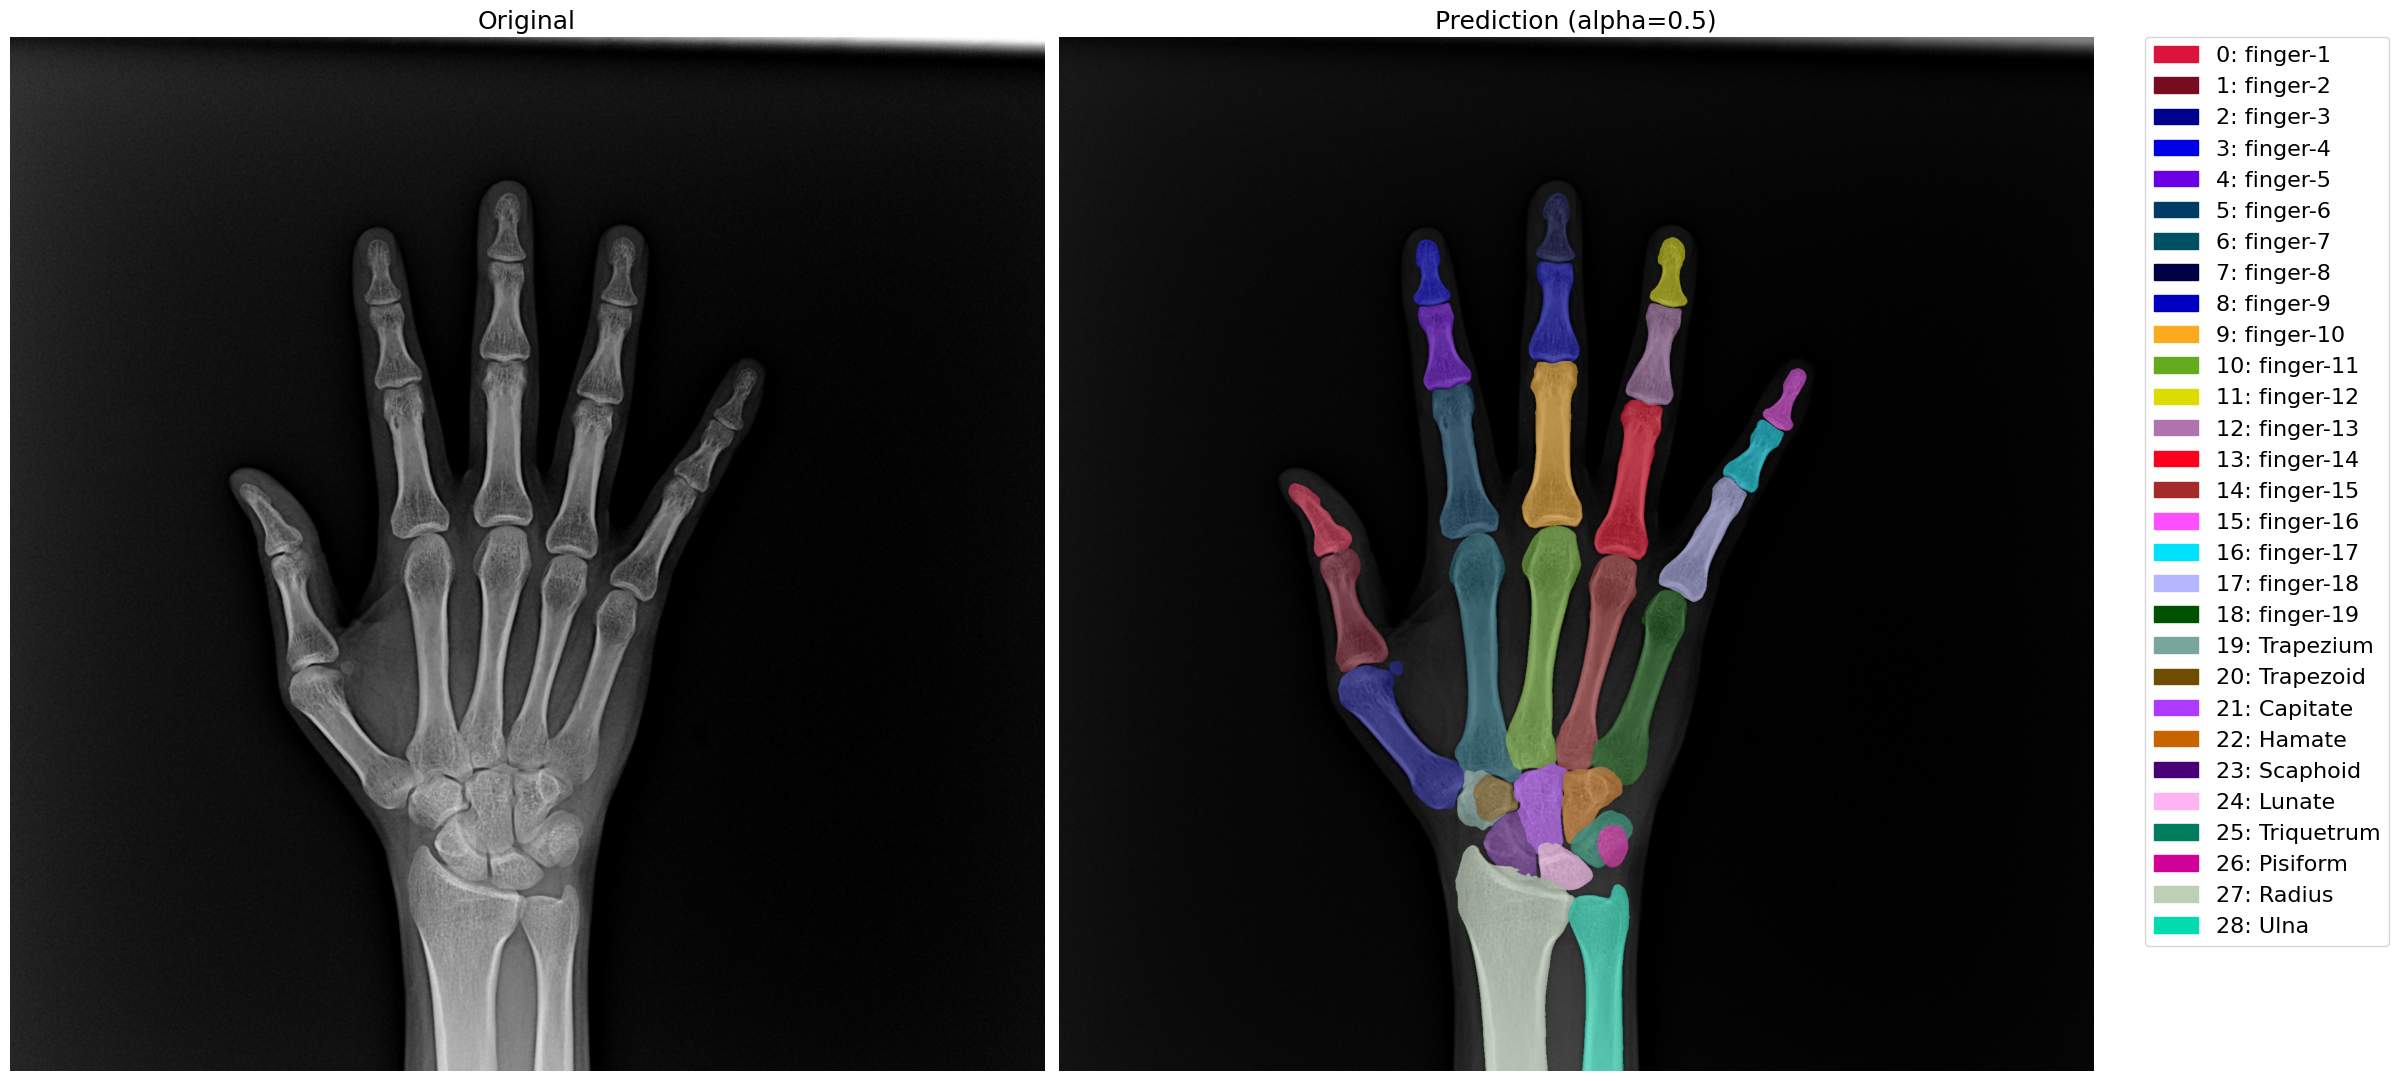

In [46]:
import matplotlib.patches as mpatches

alpha = 0.5

fig, ax = plt.subplots(1, 2, figsize=(24, 12))


ax[0].imshow(image)
ax[0].set_title("Original", fontsize=18)
ax[0].axis("off")


ax[1].imshow(image)                    
ax[1].imshow(label2rgb(preds), alpha=alpha)  
ax[1].set_title(f"Prediction (alpha={alpha})", fontsize=18)
ax[1].axis("off")


handles = []
for i, class_name in enumerate(CLASSES):
    color = np.array(PALETTE[i]) / 255.0
    patch = mpatches.Patch(color=color, label=f"{i}: {class_name}")
    handles.append(patch)

ax[1].legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=16,
)

plt.tight_layout()
plt.show()

# To CSV

In [47]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})
df.head(30)
df.to_csv("output.csv", index=False)



# TTA


In [ ]:
import ttach as tta


def test_TTA(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()
    
    # Multi-scale + flip TTA
    transforms = tta.Compose(
        [
            tta.Scale(scales=[1.0, 1.25]),  # Multi-scale
            # tta.HorizontalFlip(),       
        ]
    )
    
    # Segmentation용 TTA Wrapper
    tta_model = tta.SegmentationTTAWrapper(
        model,
        transforms,
        merge_mode="mean"
    )

    rles = []
    filename_and_class = []
    
    with torch.no_grad():
        n_class = len(CLASSES)
        
        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()

            # TTA inference
            outputs = tta_model(images)  # [B, C, H', W']

            # Sigmoid + threshold
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()

            # RLE 인코딩
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
    
    return rles, filename_and_class

In [ ]:
rles, filename_and_class = test_TTA(model, test_loader)

# visualize output.csv


In [ ]:
def rle_decode(rle_str, shape):

    if isinstance(rle_str, float) and np.isnan(rle_str):

        return np.zeros(shape, dtype=np.uint8)

    s = list(map(int, rle_str.split()))
    starts = np.array(s[0::2]) - 1  
    lengths = np.array(s[1::2])
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1

    return img.reshape(shape[0], shape[1]) 


def colorize_label_map(label_map, palette):
    """
    label_map: (H, W), 각 위치에 class index (0,1,2,...)
    palette: [[R, G, B], ...]
    """
    h, w = label_map.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for cls_idx, color in enumerate(palette, start=0):
        color_mask[label_map-1 == cls_idx] = color  
    return color_mask

In [ ]:
def visualize_from_csv(
    csv_path,
    image_dir,
    image_name,
    img_size=(2048, 2048),   # RLE 마스크가 인코딩된 사이즈
    alpha=0.5
):
    """
    csv_path: output.csv 경로
    image_dir: 원본 이미지들이 있는 디렉토리
    image_name: 시각화할 이미지 파일 이름 (예: "image1661319116107.png")
    img_size: (H, W) - RLE가 기준하고 있는 segmentation 사이즈
    alpha: overlay 비율
    """

    # CSV 로드
    df = pd.read_csv(csv_path)

    # 해당 image_name의 row만 추출
    df_img = df[df["image_name"] == image_name]
    if len(df_img) == 0:
        print(f"[WARN] {image_name} 에 해당하는 row가 CSV에 없습니다.")
        return

    # image_name -> 원본 이미지 경로
    image_path = os.path.join(image_dir, image_name)
    if not os.path.exists(image_path):
        print(f"[WARN] 원본 이미지가 없습니다: {image_path}")
        return

    # 원본 이미지 읽기 (시각화용)
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # segmentation mask와 동일한 크기로 맞추기
    if (image_rgb.shape[0], image_rgb.shape[1]) != img_size:
        image_vis = cv2.resize(image_rgb, (img_size[1], img_size[0]))
    else:
        image_vis = image_rgb

    # class name -> index 매핑
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(CLASSES)}

    # label map 초기화 (0 = background, 1~ = 각 클래스)
    label_map = np.zeros(img_size, dtype=np.int32)

    # 각 row마다 rle 디코딩해서 label_map에 쌓기
    for _, row in df_img.iterrows():
        cls_name = row["class"]
        rle_str = row["rle"]

        if cls_name not in class_to_idx:
            # CLASSES에 없는 클래스면 스킵
            print(f"[INFO] CLASSES에 없는 클래스: {cls_name} -> 스킵")
            continue

        cls_idx = class_to_idx[cls_name]

        mask = rle_decode(rle_str, img_size)  # (H, W), 0/1

        # 해당 클래스인 위치에 클래스 index 부여
        # 겹치는 영역이 있을 경우, 나중에 오는 클래스로 덮어씀
        label_map[mask == 1] = cls_idx+1

    # color mask 생성
    color_mask = colorize_label_map(label_map, PALETTE)

    # overlay
    overlay = (image_vis * (1 - alpha) + color_mask * alpha).astype(np.uint8)

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay from CSV", fontsize=18)
    ax[1].axis("off")

    # legend 생성
    handles = []
    for i, class_name in enumerate(CLASSES):
        color = np.array(PALETTE[i]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))

    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=14,
    )

    plt.tight_layout()
    plt.show()

In [ ]:
csv_path = "./output.csv"
image_dir = "../data/test_merged"  # 실제 이미지 폴더 경로로 수정
image_name = "image1661319116107.png"

visualize_from_csv(
    csv_path=csv_path,
    image_dir=image_dir,
    image_name=image_name,
    img_size=(2048, 2048),   # CSV RLE가 기준한 크기
    alpha=0.5
)

# Test one image


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [ ]:
def test_one_image_visual(model,image_root,thr=0.5,transforms=None, out_size=(2048, 2048)):
    
    image = cv2.imread(image_root)
    model = model.cuda()
    model.eval()
    
    rles = []
    filename_and_class = []

    image = cv2.imread(image_root)
    image = image / 255.
    
    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)  
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(0).cuda()
    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(image_tensor)
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > thr).cpu().numpy()[0]

    color_mask = label2rgb(preds)
    alpha = 0.5
    overlay = (image_vis * (1 - alpha) + color_mask * alpha).astype(np.uint8)
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")
    
    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")
    
    handles = []
    for i, class_name in enumerate(CLASSES):
        color = np.array(PALETTE[i]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))
    
    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=14,
    )
    
    plt.tight_layout()
    plt.show()




In [ ]:
image_root="../data/train_merged/ID283_image1664155969209.png"
# image_root=os.path.join(image_root,os.listdir(image_root)[0])
# print(image_root)
test_one_image_visual(model,
                      image_root,
                      transforms=test_tf,
                      thr=0.5, out_size=(2048, 2048))

# Visualize each class

In [ ]:
def test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=None,
    out_size=(2048, 2048),
    roi_classes=None,        
    margin=40,
    max_cols=4
):
    """
    - 기존 test_one_image_visual 방식 그대로 사용
    - roi_classes:
        * bbox 계산
        * 클래스별 확률 heatmap 시각화
    """

    assert roi_classes is not None, "roi_classes는 반드시 지정해야 해"

    model = model.cuda()
    model.eval()

    image = cv2.imread(image_root)
    image = image / 255.0

    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)
    image_tensor = torch.from_numpy(image).float().unsqueeze(0).cuda()

    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(image_tensor)
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)                 
        probs = outputs.cpu().numpy()[0]                 
        preds = (probs > thr).astype(np.uint8) 

    roi_indices = [CLASSES.index(name) for name in roi_classes]
    

    preds_roi = np.zeros_like(preds, dtype=np.uint8)
    preds_roi[roi_indices] = preds[roi_indices]
    
    color_mask = label2rgb(preds_roi)
    
    alpha = 0.5
    overlay = (
        image_vis.astype(np.float32) * (1 - alpha)
        + color_mask.astype(np.float32) * alpha
    ).astype(np.uint8)


    roi_indices = [CLASSES.index(name) for name in roi_classes]


    union = np.zeros_like(preds[0], dtype=bool)
    for idx in roi_indices:
        union |= (preds[idx] == 1)

    ys, xs = np.where(union)
    bbox = None
    if len(xs) > 0 and len(ys) > 0:
        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()

        H, W = union.shape
        y1 = max(0, y1 - margin)
        x1 = max(0, x1 - margin)
        y2 = min(H - 1, y2 + margin)
        x2 = min(W - 1, x2 + margin)

        bbox = (x1, y1, x2, y2)

    # =========================
    # 4) Overlay + bbox 시각화
    # =========================
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle(
            (x1, y1),
            (x2 - x1 + 1),
            (y2 - y1 + 1),
            fill=False,
            linewidth=3
        )
        ax[1].add_patch(rect)

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        color = np.array(PALETTE[idx]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{idx}: {name}"))

    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=12,
    )

    plt.tight_layout()
    plt.savefig("inference.png")
    plt.show()

    # =========================
    # 5) 클래스별 확률 Heatmap (ROI crop)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return preds

    x1, y1, x2, y2 = bbox
    preds_crop = preds[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = preds_crop[cls_idx]

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    
    plt.show()

    return preds


In [ ]:
roi_classes = ["Trapezium", "Trapezoid", "Capitate", "Hamate",
               "Scaphoid", "Lunate", "Triquetrum", "Pisiform"]

# ROI bbox도 이걸로 잡고, 시각화도 이걸로 하고 싶으면 vis_class_names=None

preds = test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=test_tf,
    out_size=(2048, 2048),
    roi_classes=roi_classes
)

In [ ]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def _bbox_from_union_mask(label_chw, class_indices, margin=40):
    union = np.zeros_like(label_chw[0], dtype=bool)
    for idx in class_indices:
        union |= (label_chw[idx] == 1)

    ys, xs = np.where(union)
    if len(xs) == 0 or len(ys) == 0:
        return None

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    H, W = union.shape
    y1 = max(0, y1 - margin)
    x1 = max(0, x1 - margin)
    y2 = min(H - 1, y2 + margin)
    x2 = min(W - 1, x2 + margin)

    if x2 <= x1 or y2 <= y1:
        return None
    return (x1, y1, x2, y2)


def load_gt_from_image_and_label(image_root, label_root):
    """
    return:
      image_rgb: (H,W,3) uint8
      label_chw: (C,H,W) uint8
    """
    image_bgr = cv2.imread(image_root)
    if image_bgr is None:
        raise FileNotFoundError(image_root)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    H, W = image_rgb.shape[:2]

    label_hwc = np.zeros((H, W, len(CLASSES)), dtype=np.uint8)

    with open(label_root, "r") as f:
        data = json.load(f)

    for ann in data["annotations"]:
        cname = ann["label"]
        if cname not in CLASS2IND:
            continue

        idx = CLASS2IND[cname]
        pts = np.array(ann["points"], dtype=np.int32)

        m = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(m, [pts], 1)
        label_hwc[..., idx] = m

    return image_rgb, label_hwc.transpose(2, 0, 1)


def visualize_gt_roi_only(
    image_root,
    label_root,
    roi_classes,
    margin=40,
    max_cols=4,
    alpha=0.5
):
    image_vis, label_chw = load_gt_from_image_and_label(image_root, label_root)

    roi_indices = [CLASSES.index(n) for n in roi_classes]

    # roi_classes만 남기기
    label_roi = np.zeros_like(label_chw, dtype=np.uint8)
    label_roi[roi_indices] = label_chw[roi_indices]

    # =========================
    # Overlay + bbox
    # =========================
    color_mask = label2rgb(label_roi)   # 네가 정의한 label2rgb
    overlay = (image_vis.astype(np.float32) * (1 - alpha)
               + color_mask.astype(np.float32) * alpha).astype(np.uint8)

    bbox = _bbox_from_union_mask(label_roi, roi_indices, margin=margin)

    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title("GT Overlay (roi_classes only)", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2-x1+1, y2-y1+1,
                              fill=False, linewidth=3)
        ax[1].add_patch(rect)
    else:
        print("[warn] ROI bbox를 찾지 못함")

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        handles.append(
            mpatches.Patch(color=np.array(PALETTE[idx]) / 255.0,
                            label=f"{idx}: {name}")
        )

    ax[1].legend(handles=handles,
                 bbox_to_anchor=(1.05, 1),
                 loc="upper left",
                 fontsize=12)

    plt.tight_layout()
    plt.show()

    # =========================
    # bbox crop + 클래스별 시각화 (네 블록 그대로)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return

    x1, y1, x2, y2 = bbox
    label_crop = label_roi[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = label_crop[cls_idx].astype(np.float32)

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
visualize_gt_roi_only(
    image_root="../data/train_merged/ID283_image1664155969209.png",
    label_root="../data/train_merged/ID283_image1664155969209.json",
    roi_classes=roi_classes,
    margin=40,
    max_cols=4
)